In [134]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import dataframe_image as dfi
import plotly.graph_objects as go
from venn import venn
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler

import missingno as msno
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 8 
MEDIUM_SIZE = 30
BIGGER_SIZE = 12

mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False})
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

### 시각화 차트 함수

In [76]:
# Bar Chart
def draw_barchart(data, x, y, figsize=(12,10), palette='flare'):
    sns.set(font_scale = 1.2, rc={'figure.figsize':figsize}, style='whitegrid')
    ax = sns.barplot(y=y, x=x, data=data, palette=palette)
    initialx=0
    for p in ax.patches:
        ax.text(p.get_width()+1,initialx+p.get_height()/8,'{:1.0f}'.format(p.get_width()))
        initialx+=1

In [142]:
# Heatmap
def draw_heatmap(data, xlabel, ylabel, 
                 figsize=(30,20), palette='Blues',
                 vmin=0, vmax=1000,
                 isNormalized=False):
    xticklabels = list(map(lambda x: x[1], data.columns))
    yticklabels = list(data.index)
    
    if isNormalized:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(data)
        data = pd.DataFrame(data,
                            index = yticklabels,
                            columns = xticklabels)
    else:
        data = data.astype(int)

    sns.set(font_scale = 1.2, rc={'figure.figsize':figsize})
    sns.heatmap(data, 
                xticklabels=xticklabels, yticklabels=yticklabels,
                annot=True, cmap=palette, 
                fmt=',d', linewidths=1, vmin=vmin, vmax=vmax)

    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()

In [149]:
# Clutermap
def draw_clustermap(data, xlabel, ylabel, 
                    figsize=(30,20), palette='Blues',
                    vmin=0, vmax=1000,
                    isNormalized=False):
    xticklabels = list(map(lambda x: x[1], data.columns))
    yticklabels = list(data.index)
    
    if isNormalized:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(data)
        data = pd.DataFrame(data,
                            index = yticklabels,
                            columns = xticklabels)
    else:
        data = data.astype(int)

    sns.set(font_scale = 1.2, rc={'figure.figsize':figsize})
    sns.clustermap(data, 
                   xticklabels=xticklabels, yticklabels=yticklabels,
                   tree_kws=dict(linewidths=2),
                   annot=True, cmap=palette,
                   fmt='.2f', linewidths=1,
                   figsize=figsize,
                   method='ward', metric='euclidean')

    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()

## PostgreSQL DB 연결

In [77]:
host = ''
dbname = ''
user = ''
password = ''
sslmode = 'require'

conn_string = f'host={host} user={user} dbname={dbname} password={password} sslmode={sslmode}'
conn = psycopg2.connect(conn_string)
print("Connection established")

cursor = conn.cursor()

Connection established


## 쿼리 시나리오 실행

### 데이터 조회 쿼리를 실행하고 결과를 데이터프레임으로 반환하는 함수

In [17]:
def execute_query(query, columns):
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns=columns)
    return df

''' [사용방법]
query = ''
columns = ''
execute_query(query, columns)
'''

" [사용방법]\nquery = ''\ncolumns = ''\nexecute_query(query, columns)\n"

### Phecode ㅡ UMLS ㅡ ICD 코드 매핑된 테이블 확인

In [15]:
query = '''
SELECT *
FROM phecode_map;
'''
columns = ['phecode','umls_cui','icd9cm','icd10cm','icd10']

df = execute_query(query, columns)
df

phecode  umls_cui icd9cm  icd10cm  icd10
0          8.0  C0008354    001     None   None
1          8.0  C0008354  001.0     None   None
2          8.0  C0343372  001.1     None   None
3          8.0  C0008354  001.9     None   None
4          8.0  C0275976    002     None   None
...        ...       ...    ...      ...    ...
170245   216.1  C2910634   None   Z13.85   None
170246   216.1  C2921402   None  Z13.850   None
170247   216.1  C2910635   None  Z13.858   None
170248   216.1  C2910636   None   Z13.88   None
170249   216.1  C2910639   None    Z13.9  Z13.9

[170250 rows x 5 columns]

### PheWAS의 Phecode + Phenotype과 WHO-ART 부작용 용어 매핑

In [16]:
query = '''
SELECT DISTINCT pw.phecode, pw.phenotype, 
       LOWER(term) AS whoart_term
FROM phewas pw, phecode_map pm, umls_whoart uw
WHERE pw.phecode = pm.phecode
AND pm.umls_cui = uw.umls_cui
ORDER BY phecode;
'''
columns = ['phecode','phenotype','whoart_term']

df = execute_query(query, columns)
df

phecode                                          phenotype  \
0       10.0                                       Tuberculosis   
1       10.0                                       Tuberculosis   
2     1000.0                                              Burns   
3     1000.0                                              Burns   
4     1002.0  Symptoms concerning nutrition, metabolism, and...   
...      ...                                                ...   
2954   994.0                                    Sepsis and SIRS   
2955   994.2                                             Sepsis   
2956   994.2                                             Sepsis   
2957   994.2                                             Sepsis   
2958  994.21                                       Septic shock   

                           whoart_term  
0                   erythema induratum  
1     tuberculosis of bones and joints  
2                                 burn  
3                     oesophageal burn  
4                      weight decrease  
...                                ...  
2954                      shock septic  
2955                            sepsis  
2956                       septicaemia  
2957                      shock septic  
2958                      shock septic  

[2959 rows x 3 columns]

### PheWAS의 Phecode + Phenotype과 KAERS 약물 연결

In [17]:
query = '''
WITH phe_who AS (
--    PheWAS Phenotype과 WHO-ART 부작용 용어를 연결한 임시 테이블
    SELECT DISTINCT pw.phecode, pw.phenotype, term AS whoart_term
    FROM phewas pw, phecode_map pm, umls_whoart uw
    WHERE pw.phecode = pm.phecode
    AND pm.umls_cui = uw.umls_cui
    ORDER BY phecode
), kaers AS (
--    KAERS 약물별 WHO-ART 부작용 용어를 연결한 임시 테이블
    SELECT DISTINCT drug_name, atc_code, english_term AS whoart_term
    FROM kaers_drug_adr kda, kaers_drug kd, kaers_adr ka
    WHERE kda.kaers_drug_id = kd.kaers_drug_id
    AND kda.kaers_adr_id = ka.kaers_adr_id
)

SELECT DISTINCT phecode, phenotype, drug_name, atc_code
FROM phe_who, kaers
WHERE phe_who .whoart_term = kaers.whoart_term;
'''
columns = ['phecode','phenotype','drug_name','atc_code']

df = execute_query(query, columns)
df

phecode     phenotype                         drug_name atc_code
0         10.0  Tuberculosis         absorbable gelatin sponge  B02BC01
1         10.0  Tuberculosis                    acetylcysteine  R05CB01
2         10.0  Tuberculosis              acetylsalicylic acid  B01AC06
3         10.0  Tuberculosis                       amino acids  B05BA01
4         10.0  Tuberculosis                      atorvastatin  C10AA05
...        ...           ...                               ...      ...
233466  994.21  Septic shock  Vitamin B-complex with vitamin C    A11EB
233467  994.21  Septic shock           Vitamin D and analogues    A11CC
233468  994.21  Septic shock                      voriconazole  J02AC03
233469  994.21  Septic shock                   zoledronic acid  M05BA08
233470  994.21  Septic shock                          zolpidem  N05CF02

[233471 rows x 4 columns]

### PheWAS의 Phecode + Phenotype과 SIDER 약물 연결

In [18]:
query = '''
WITH phe AS (
--    PheWAS Phenotype과 UMLS CUI를 연결한 임시 테이블
    SELECT DISTINCT pw.phecode, pw.phenotype, pm.umls_cui
    FROM phewas pw, phecode_map pm
    WHERE pw.phecode = pm.phecode
    ORDER BY phecode
), sider AS (
--    SIDER 약물별 UMLS CUI를 연결한 임시 테이블
    SELECT DISTINCT drug_name, sds.stitch_id, ss.umls_cui_label
    FROM sider_drug_se sds, sider_drug sd, sider_se ss
    WHERE sds.stitch_id = sd.stitch_id
    AND sds.sider_se_id = ss.sider_se_id
)

SELECT DISTINCT phecode, phenotype, drug_name, stitch_id
FROM phe, sider
WHERE phe.umls_cui = sider.umls_cui_label;
'''
columns = ['phecode','phenotype','drug_name','stitch_id']

df = execute_query(query, columns)
df

phecode     phenotype     drug_name     stitch_id
0         10.0  Tuberculosis   tofacitinib  CID109818231
1       1000.0         Burns    bortezomib  CID100093860
2       1000.0         Burns     capsaicin  CID100002548
3       1000.0         Burns     malathion  CID100004004
4       1000.0         Burns  testosterone  CID100005408
...        ...           ...           ...           ...
118187  994.21  Septic shock   tigecycline  CID154681041
118188  994.21  Septic shock        TMC207  CID100656892
118189  994.21  Septic shock   trabectedin  CID100003199
118190  994.21  Septic shock   vincristine  CID100005978
118191  994.21  Septic shock    vinflunine  CID100157688

[118192 rows x 4 columns]

### PheWAS의 Phecode별 KAERS 약물 개수 확인

In [19]:
query = '''
WITH phe_who AS (
    SELECT DISTINCT pw.phecode, pw.phenotype, term AS whoart_term
    FROM phewas pw, phecode_map pm, umls_whoart uw
    WHERE pw.phecode = pm.phecode
    AND pm.umls_cui = uw.umls_cui
    ORDER BY phecode
), kaers AS (
    SELECT DISTINCT drug_name, atc_code, english_term AS whoart_term
    FROM kaers_drug_adr kda, kaers_drug kd, kaers_adr ka
    WHERE kda.kaers_drug_id = kd.kaers_drug_id
    AND kda.kaers_adr_id = ka.kaers_adr_id
)

SELECT DISTINCT phe_kares.phecode, phe_kares.phenotype
      , COUNT(*) OVER (PARTITION BY phe_kares.phecode) kares_drug_count
FROM (
    SELECT DISTINCT phe_who.phecode, phe_who.phenotype, kaers.drug_name, kaers.atc_code
    FROM phe_who, kaers
    WHERE phe_who.whoart_term = kaers.whoart_term
    ORDER BY phecode) phe_kares
ORDER BY phecode;
'''
columns = ['Phecode','Phenotype','KAERS Drug Count']

phe_ka_cnt = execute_query(query, columns)
phe_ka_cnt

Phecode                                          Phenotype  \
0      10.0                                       Tuberculosis   
1    1000.0                                              Burns   
2    1002.0  Symptoms concerning nutrition, metabolism, and...   
3    1004.0  Other signs and symptoms involving emotional s...   
4    1005.0                                     Other symptoms   
..      ...                                                ...   
880   971.0  Poisoning by drugs primarily affecting the aut...   
881   984.0  Toxic effect of lead and its compounds (includ...   
882   994.0                                    Sepsis and SIRS   
883   994.2                                             Sepsis   
884  994.21                                       Septic shock   

     KAERS Drug Count  
0                  55  
1                 206  
2                 721  
3                 442  
4                   3  
..                ...  
880                 6  
881                 1  
882               667  
883               667  
884               436  

[885 rows x 3 columns]

In [20]:
phe_ka_cnt.sort_values('KAERS Drug Count', ascending=False)[:10]

Phecode                                 Phenotype  KAERS Drug Count
852   789.0                       Nausea and vomiting              1614
747   698.0           Pruritus and related conditions              1585
718   687.0                   Symptoms affecting skin              1519
719   687.1  Rash and other nonspecific skin eruption              1475
485   512.0      Other symptoms of respiratory system              1467
876   947.0                                 Urticaria              1452
562   561.0       Symptoms involving digestive system              1432
252   339.0                  Other headache syndromes              1425
563   561.1                                  Diarrhea              1414
850   785.0                            Abdominal pain              1409

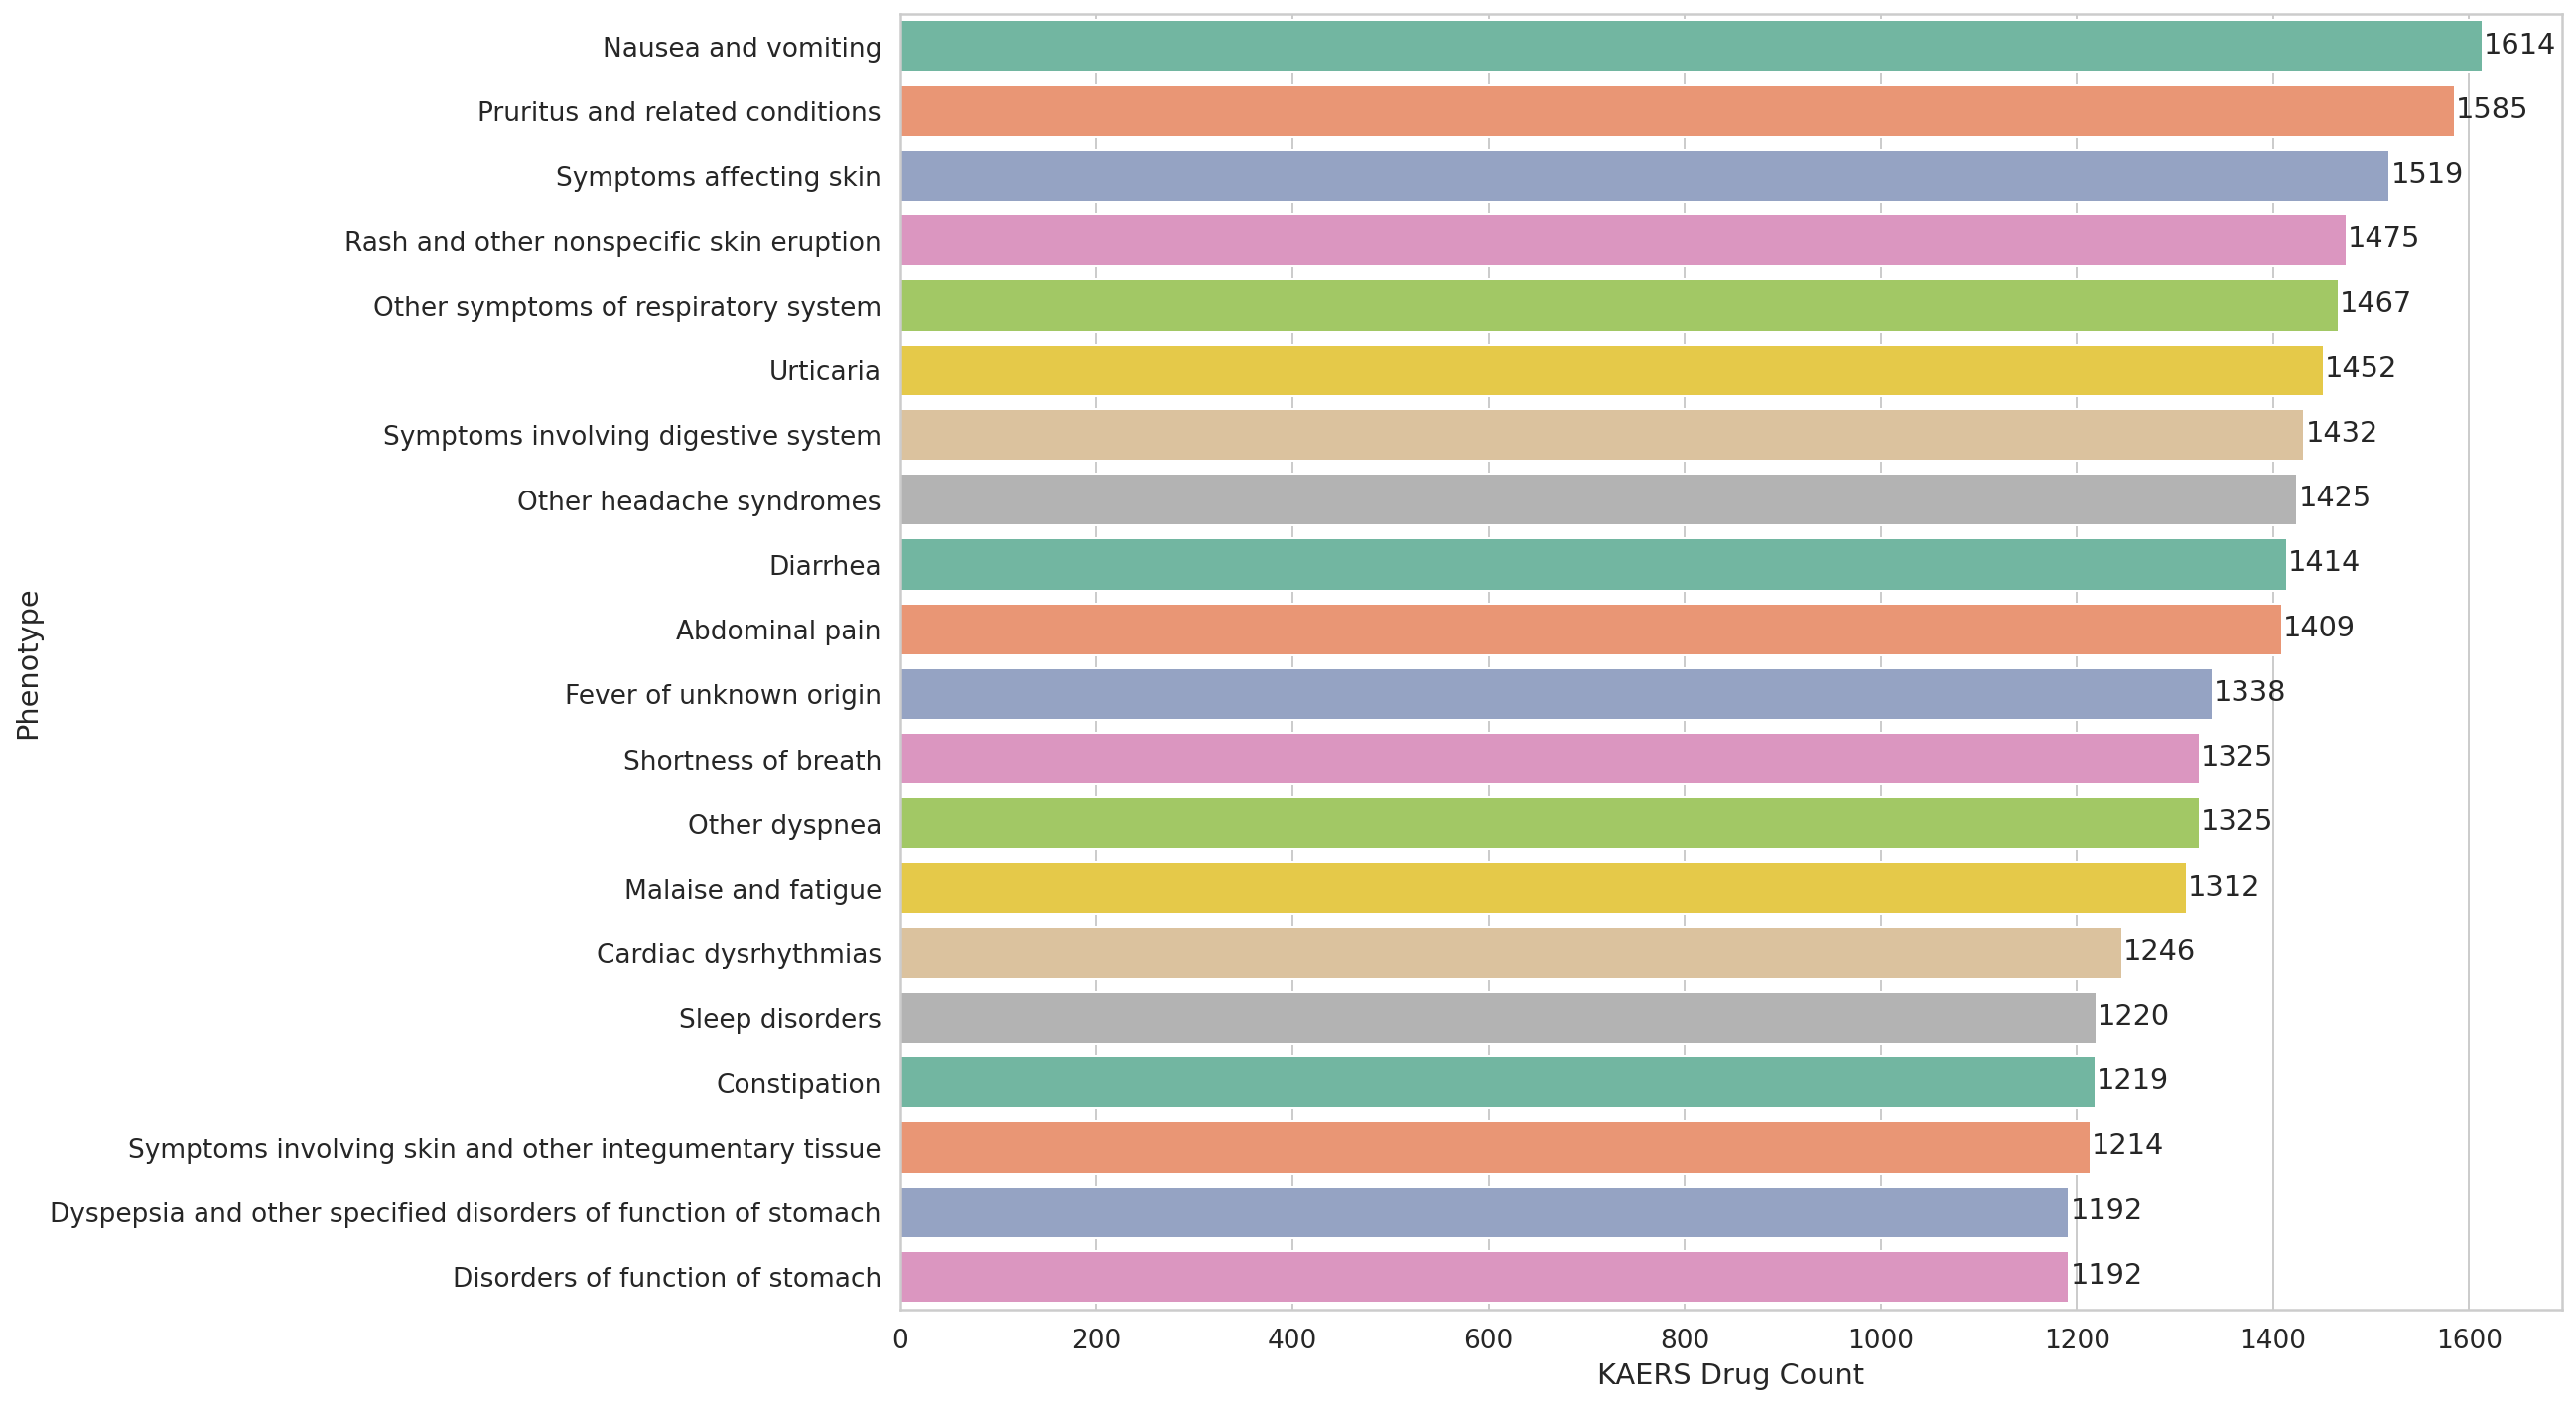

In [29]:
draw_barchart(phe_ka_cnt.sort_values('KAERS Drug Count', ascending=False)[:20],
              figsize=(15,12),
              x='KAERS Drug Count', y='Phenotype',
              palette='Set2')

### PheWAS의 Phecode별 SIDER 약물 개수 확인

In [22]:
query = '''
WITH phe AS (
    SELECT DISTINCT pw.phecode, pw.phenotype, pm.umls_cui
    FROM phewas pw, phecode_map pm
    WHERE pw.phecode = pm.phecode
    ORDER BY phecode
), sider AS (
    SELECT DISTINCT drug_name, sds.stitch_id, ss.umls_cui_meddra
    FROM sider_drug_se sds, sider_drug sd, sider_se ss
    WHERE sds.stitch_id = sd.stitch_id
    AND sds.sider_se_id = ss.sider_se_id
)

SELECT DISTINCT phe_sider.phecode, phe_sider.phenotype
        , COUNT(*) OVER (PARTITION BY phe_sider.phecode) sider_drug_count
FROM (
    SELECT DISTINCT phe.phecode, phe.phenotype, sider.drug_name, sider.stitch_id
    FROM phe, sider
    WHERE phe.umls_cui = sider.umls_cui_meddra
    ORDER BY phecode) phe_sider
ORDER BY phecode;
'''
columns = ['Phecode','Phenotype','SIDER Drug Count']

phe_si_cnt = execute_query(query, columns)
phe_si_cnt

Phecode                                          Phenotype  \
0       10.0                                       Tuberculosis   
1     1000.0                                              Burns   
2     1001.0                                Foreign body injury   
3     1003.0                                       Sudden death   
4     1004.0  Other signs and symptoms involving emotional s...   
...      ...                                                ...   
1233   989.0  Toxic effect of other substances, chiefly nonm...   
1234   994.0                                    Sepsis and SIRS   
1235   994.1     Systemic inflammatory response syndrome (SIRS)   
1236   994.2                                             Sepsis   
1237  994.21                                       Septic shock   

      SIDER Drug Count  
0                    1  
1                    4  
2                    1  
3                   16  
4                  567  
...                ...  
1233                23  
1234               199  
1235                 2  
1236               199  
1237                35  

[1238 rows x 3 columns]

In [23]:
phe_si_cnt.sort_values('SIDER Drug Count', ascending=False)[:10]

Phecode                                          Phenotype  \
1160   789.0                                Nausea and vomiting   
1219   939.0  Atopic/contact dermatitis due to other or unsp...   
359    339.0                           Other headache syndromes   
953    687.0                            Symptoms affecting skin   
954    687.1           Rash and other nonspecific skin eruption   
748    561.0                Symptoms involving digestive system   
1223   949.0                                   Allergies, other   
749    561.1                                           Diarrhea   
1175   798.0                                Malaise and fatigue   
1158   785.0                                     Abdominal pain   

      SIDER Drug Count  
1160              1225  
1219              1126  
359               1115  
953               1110  
954               1088  
748               1012  
1223               988  
749                981  
1175               976  
1158               971

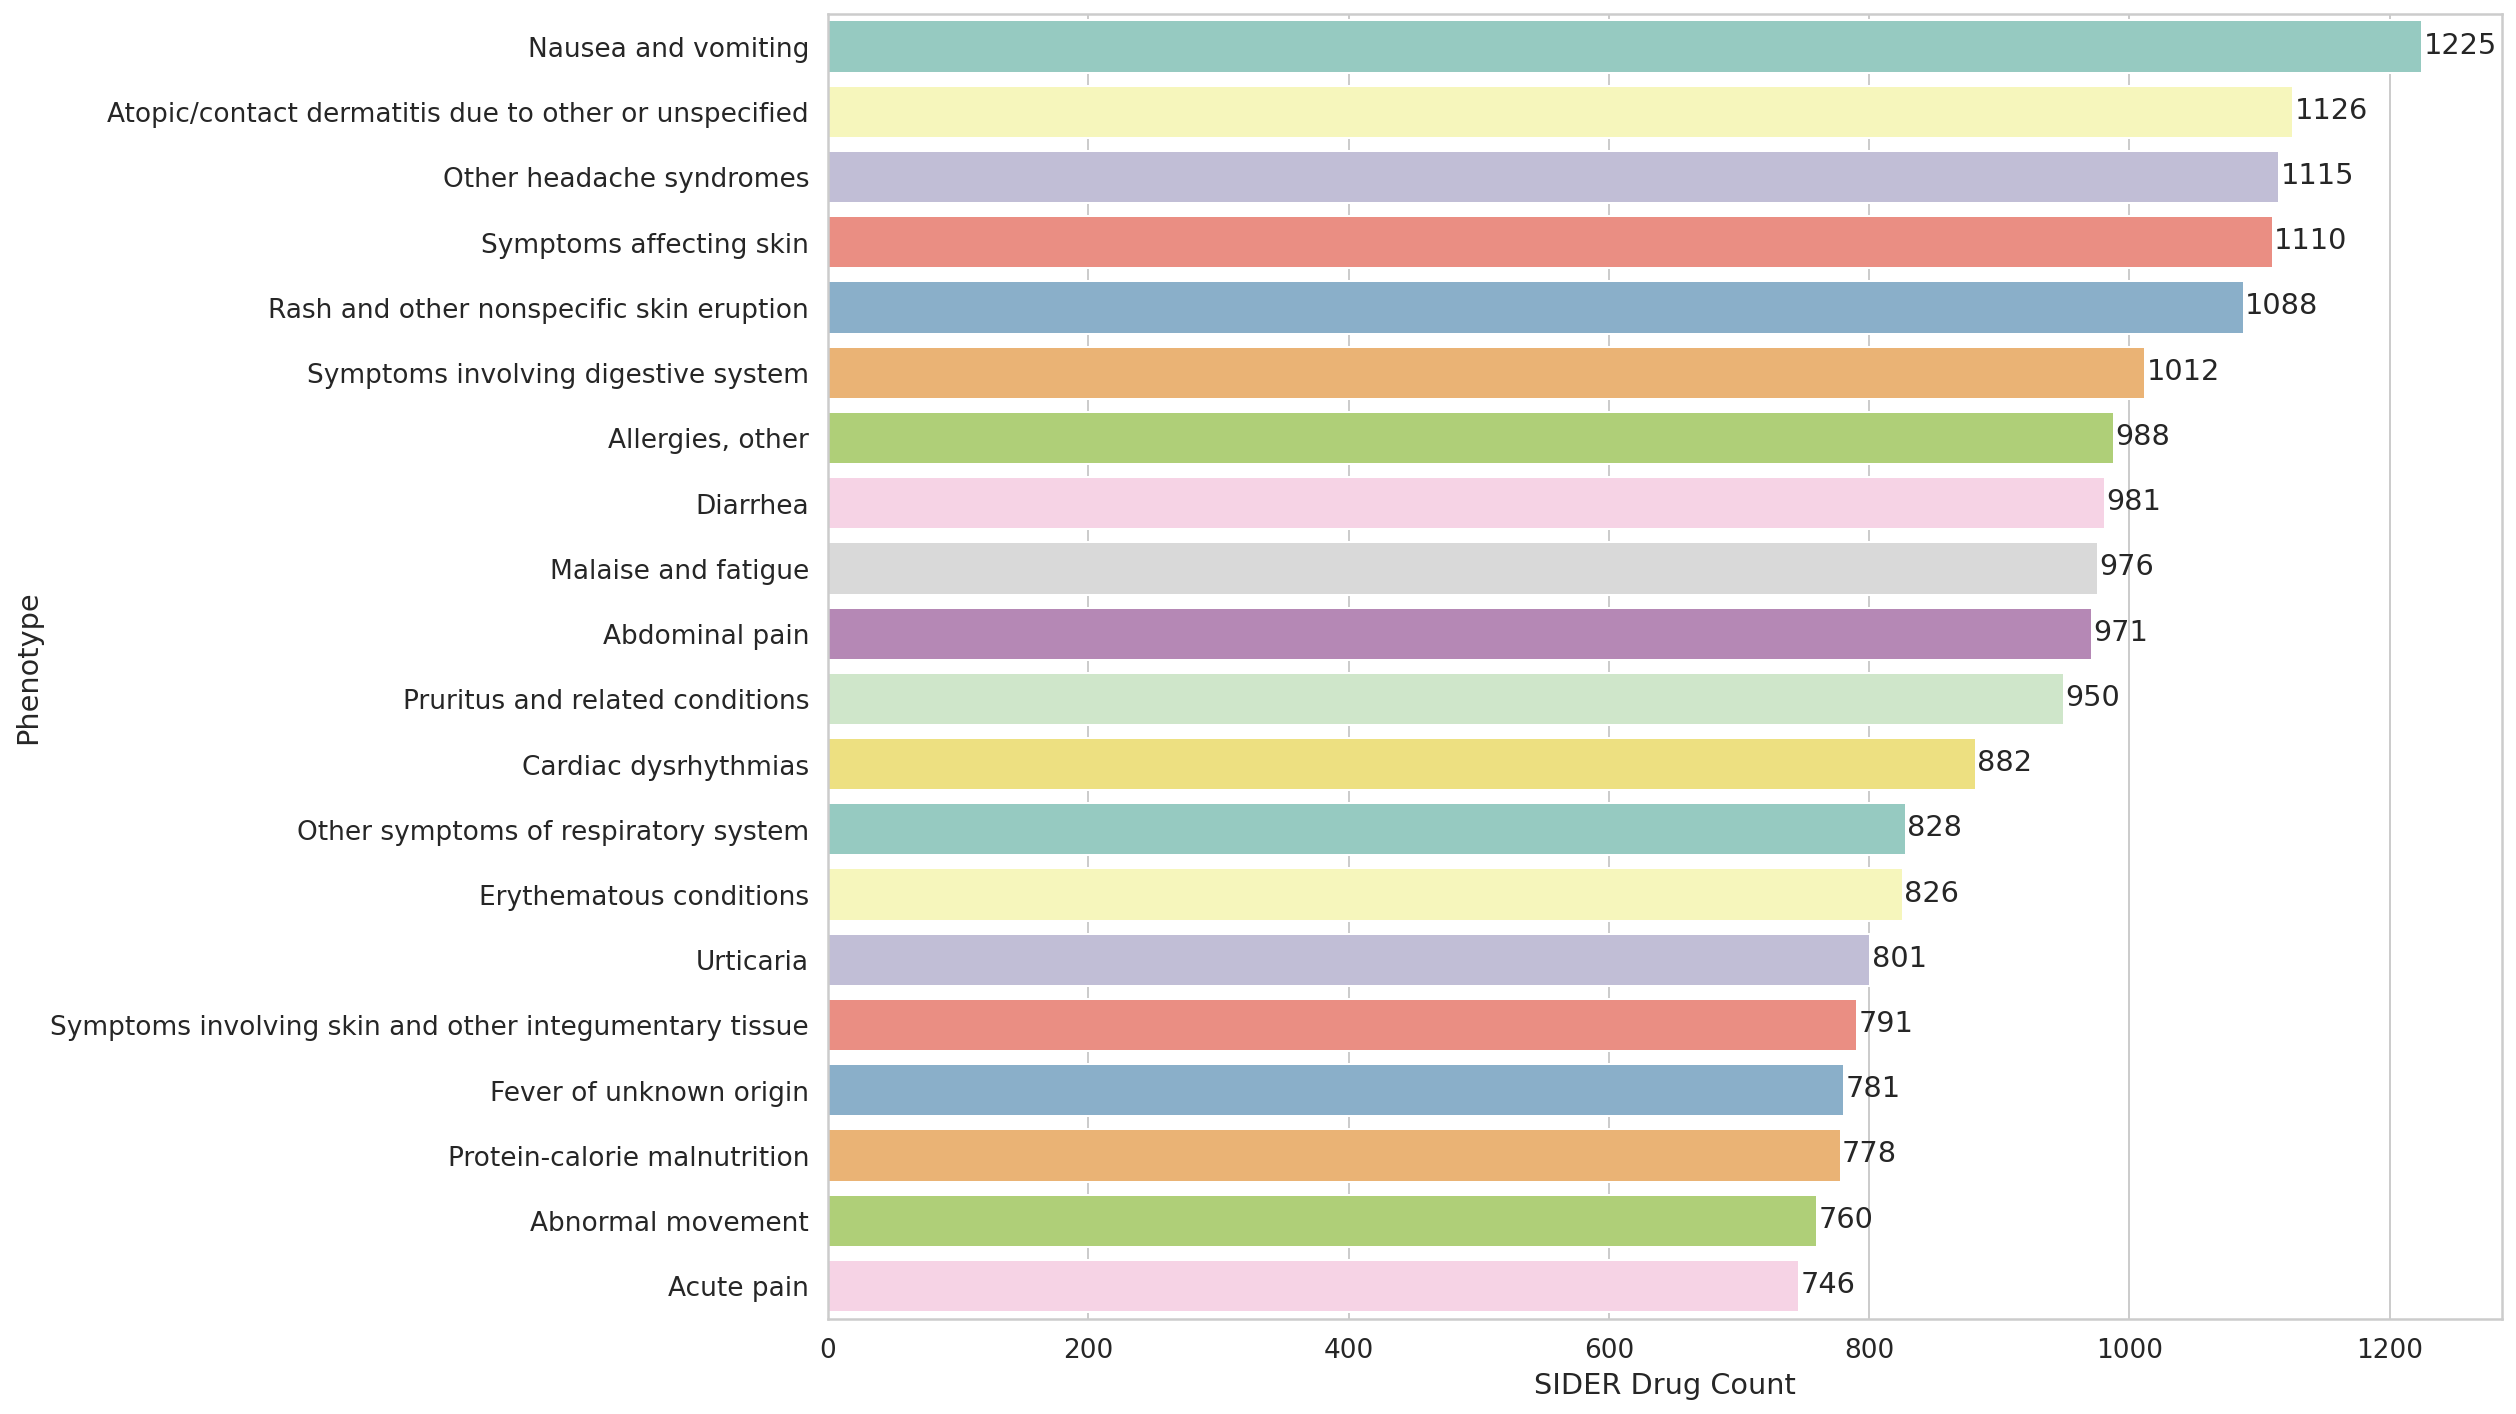

In [30]:
draw_barchart(phe_si_cnt.sort_values('SIDER Drug Count', ascending=False)[:20], 
              figsize=(15,12),
              x='SIDER Drug Count', y='Phenotype',
              palette='Set3')

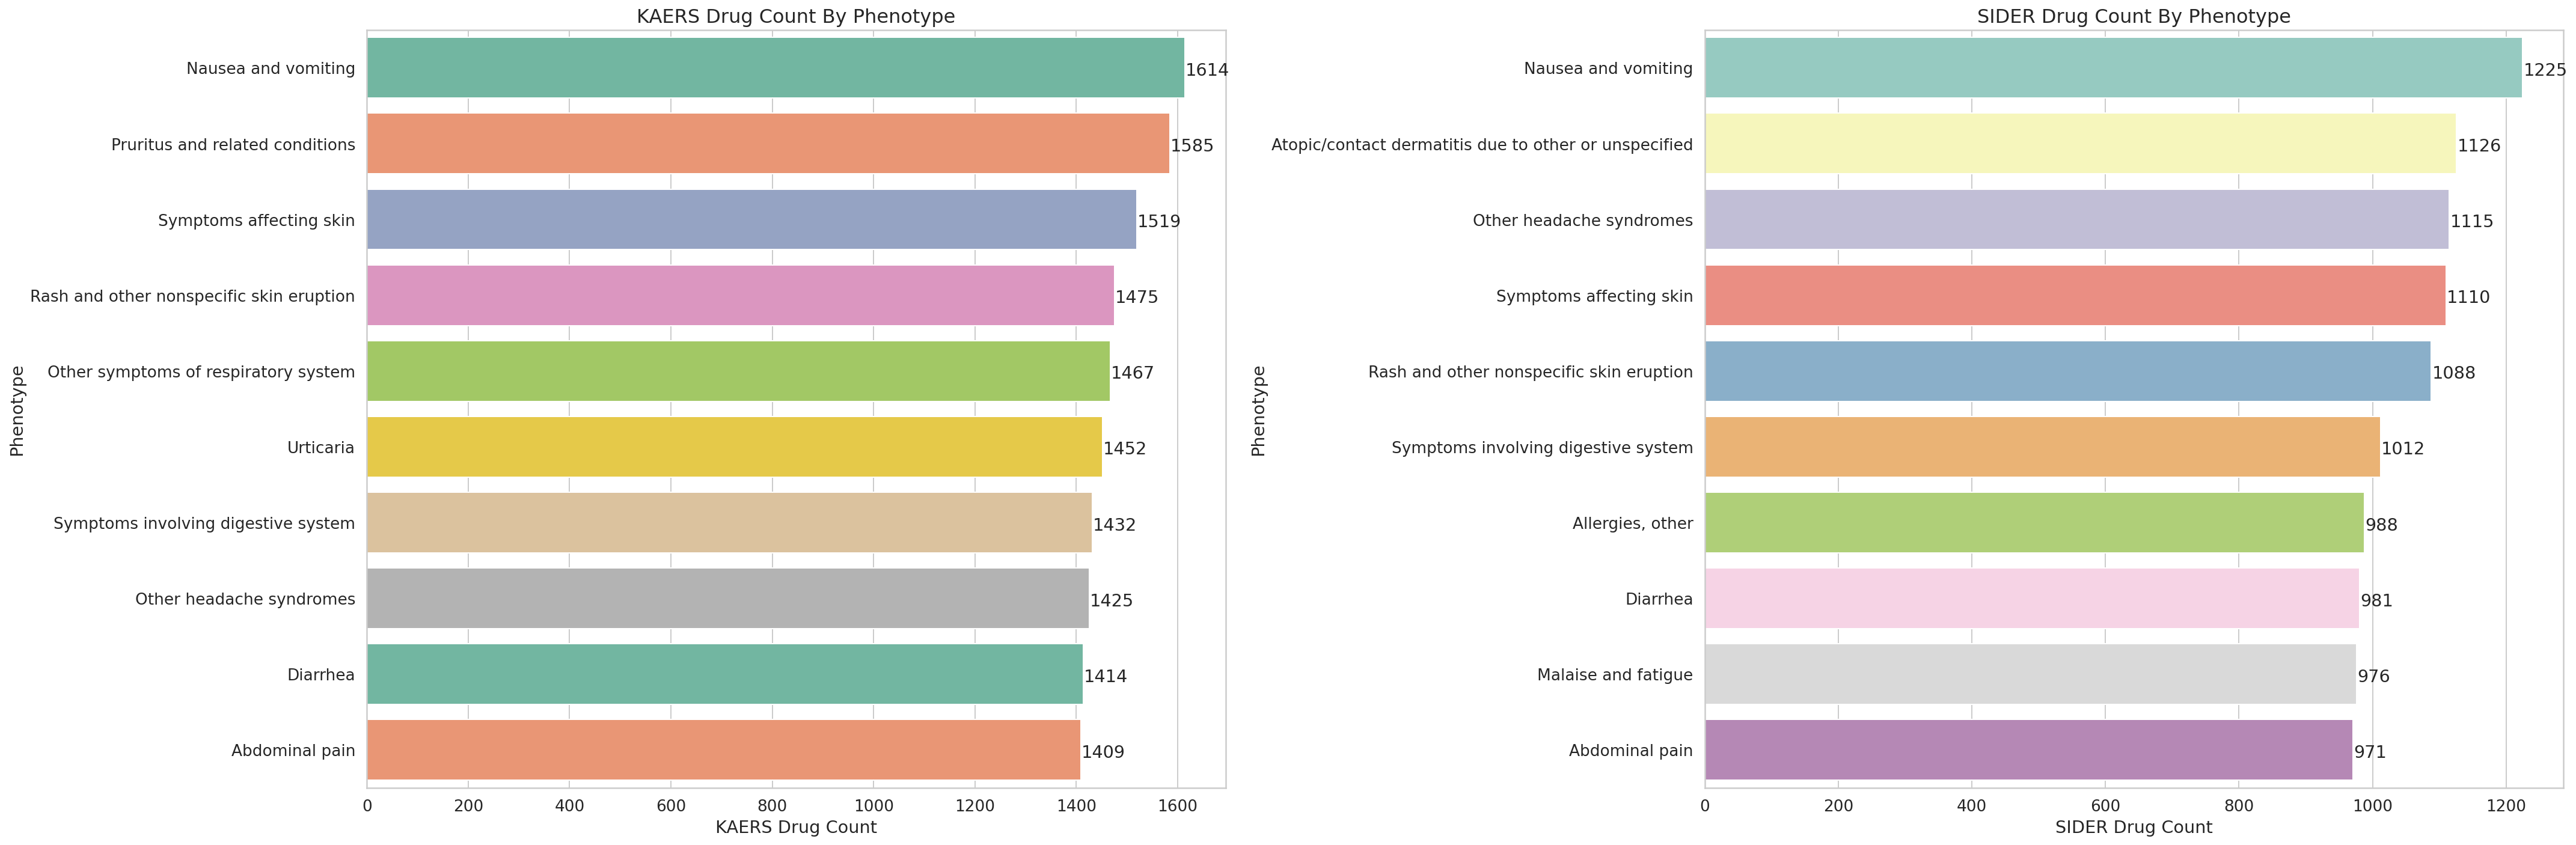

In [45]:
plt.figure(figsize=(30,10))

plt.subplot(1, 2, 1)
draw_barchart(phe_ka_cnt.sort_values('KAERS Drug Count', ascending=False)[:10],
              x='KAERS Drug Count', y='Phenotype',
              palette='Set2')
plt.title('KAERS Drug Count By Phenotype', fontsize=16)

plt.subplot(1, 2, 2)
draw_barchart(phe_si_cnt.sort_values('SIDER Drug Count', ascending=False)[:10], 
              x='SIDER Drug Count', y='Phenotype',
              palette='Set3')
plt.title('SIDER Drug Count By Phenotype', fontsize=16)

plt.tight_layout()
plt.show()

### KAERS 약물별 부작용 용어 개수 (내림차순)

In [132]:
query = '''
WITH kaers AS (
     SELECT DISTINCT drug_name||' / '||atc_code AS drug,
     drug_name, atc_code, INITCAP(english_term) AS whoart_term
     FROM kaers_drug_adr kda, kaers_drug kd, kaers_adr ka
     WHERE kda.kaers_drug_id = kd.kaers_drug_id
     AND kda.kaers_adr_id = ka.kaers_adr_id
)

SELECT DISTINCT drug, drug_name, atc_code
    , COUNT(*) OVER (PARTITION BY drug_name, atc_code) side_effect_count
FROM kaers
ORDER BY side_effect_count DESC;
'''
columns = ['Drug','Drug name','ATC code','Adverse Effect Count']

ka_adr_cnt = execute_query(query, columns)
ka_adr_cnt

Drug                 Drug name ATC code  \
0                 atorvastatin / C10AA05              atorvastatin  C10AA05   
1                  paracetamol / N02BE01               paracetamol  N02BE01   
2         acetylsalicylic acid / B01AC06      acetylsalicylic acid  B01AC06   
3                    metformin / A10BA02                 metformin  A10BA02   
4                 prednisolone / H02AB06              prednisolone  H02AB06   
...                                  ...                       ...      ...   
2199                   various / M02AX10                   various  M02AX10   
2200                vinburnine / C04AX17                vinburnine  C04AX17   
2201            Vitamin A, plain / A11CA          Vitamin A, plain    A11CA   
2202                vonoprazan / A02BC08                vonoprazan  A02BC08   
2203  zoster, purified antigen / J07BK03  zoster, purified antigen  J07BK03   

      Adverse Effect Count  
0                     1722  
1                     1654  
2                     1611  
3                     1608  
4                     1553  
...                    ...  
2199                     1  
2200                     1  
2201                     1  
2202                     1  
2203                     1  

[2204 rows x 4 columns]

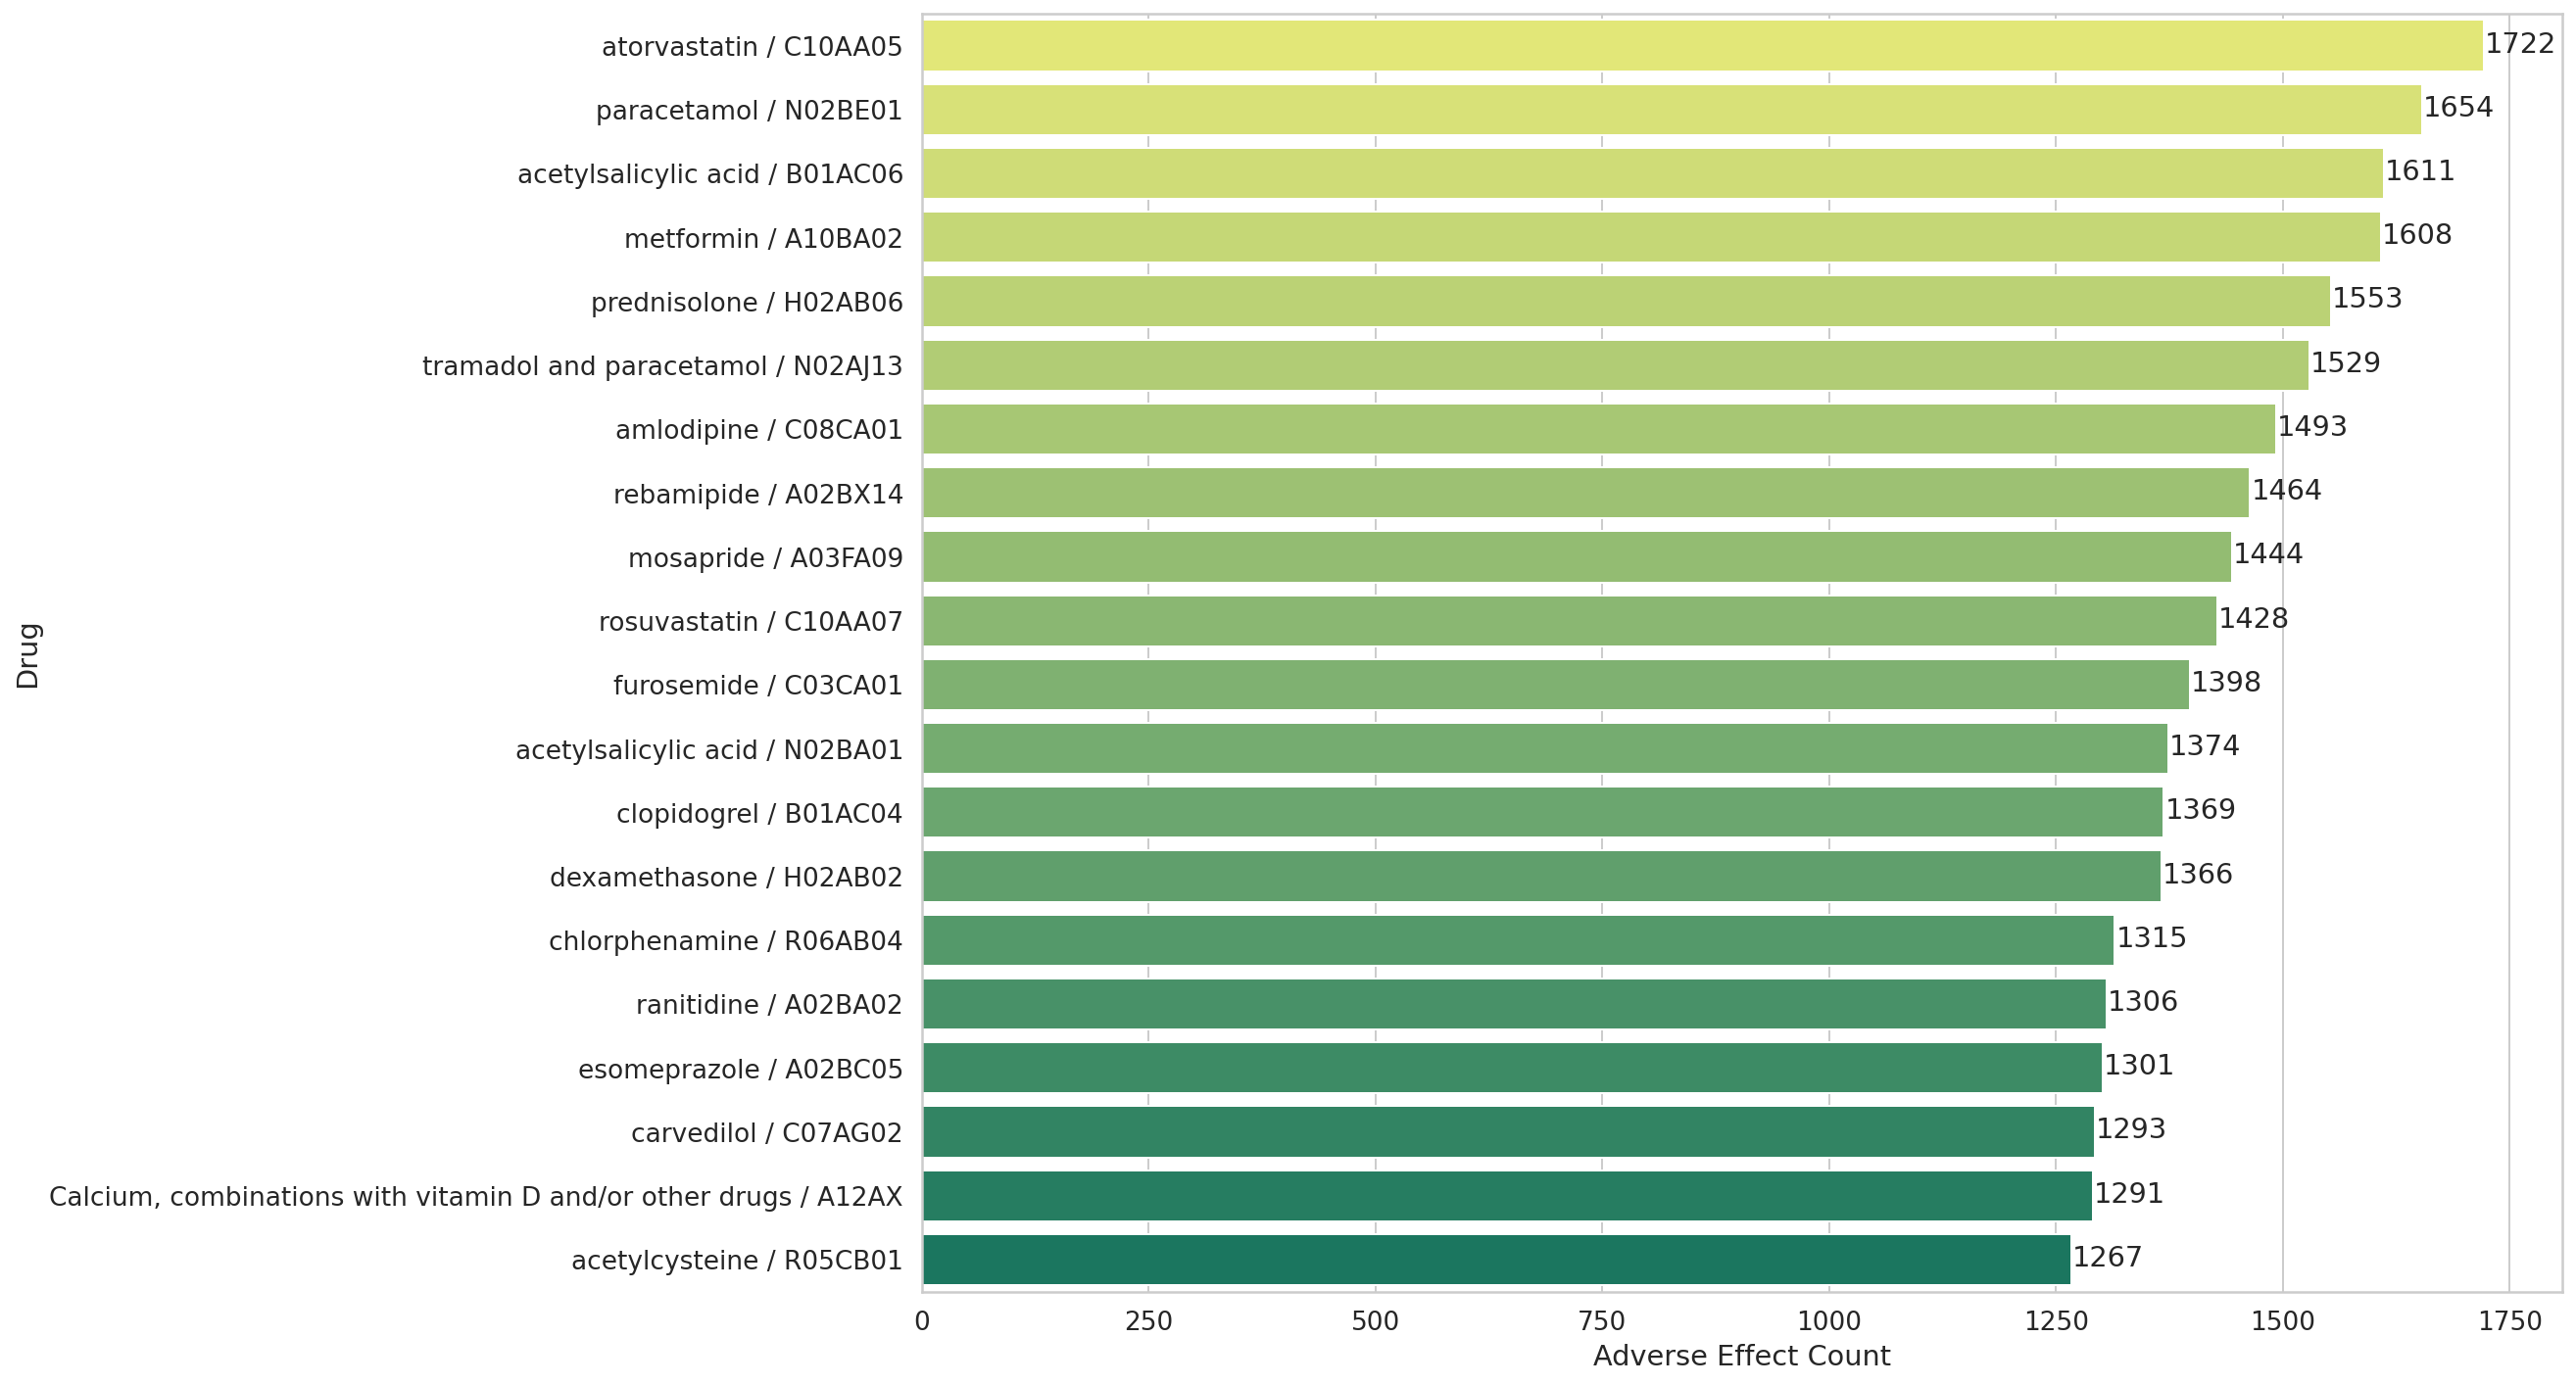

In [169]:
draw_barchart(ka_adr_cnt[:20], figsize=(15,12),
              x='Adverse Effect Count', y='Drug',
              palette='summer_r')

### KAERS 부작용 용어별 약물 개수 (내림차순)

In [99]:
query = '''
WITH kaers AS (
     SELECT DISTINCT drug_name, atc_code, INITCAP(english_term) AS whoart_term
     FROM kaers_drug_adr kda, kaers_drug kd, kaers_adr ka
     WHERE kda.kaers_drug_id = kd.kaers_drug_id
     AND kda.kaers_adr_id = ka.kaers_adr_id
)

SELECT DISTINCT whoart_term
                , COUNT(*) OVER (PARTITION BY whoart_term) drug_count
FROM kaers
ORDER BY drug_count DESC;
'''
columns = ['WHO-ART Term', 'Drug Count']

ka_drug_cnt = execute_query(query, columns)
ka_drug_cnt

WHO-ART Term  Drug Count
0                                  Nausea        1530
1                               Dizziness        1467
2                                 Itching        1455
3                                    Rash        1452
4                               Urticaria        1425
...                                   ...         ...
4264            Glucosuria False Positive           1
4265                     Le Test Abnormal           1
4266              Granulocytopenia Severe           1
4267  Dissecting Coronary Artery Aneurysm           1
4268                   Gray Baby Syndrome           1

[4269 rows x 2 columns]

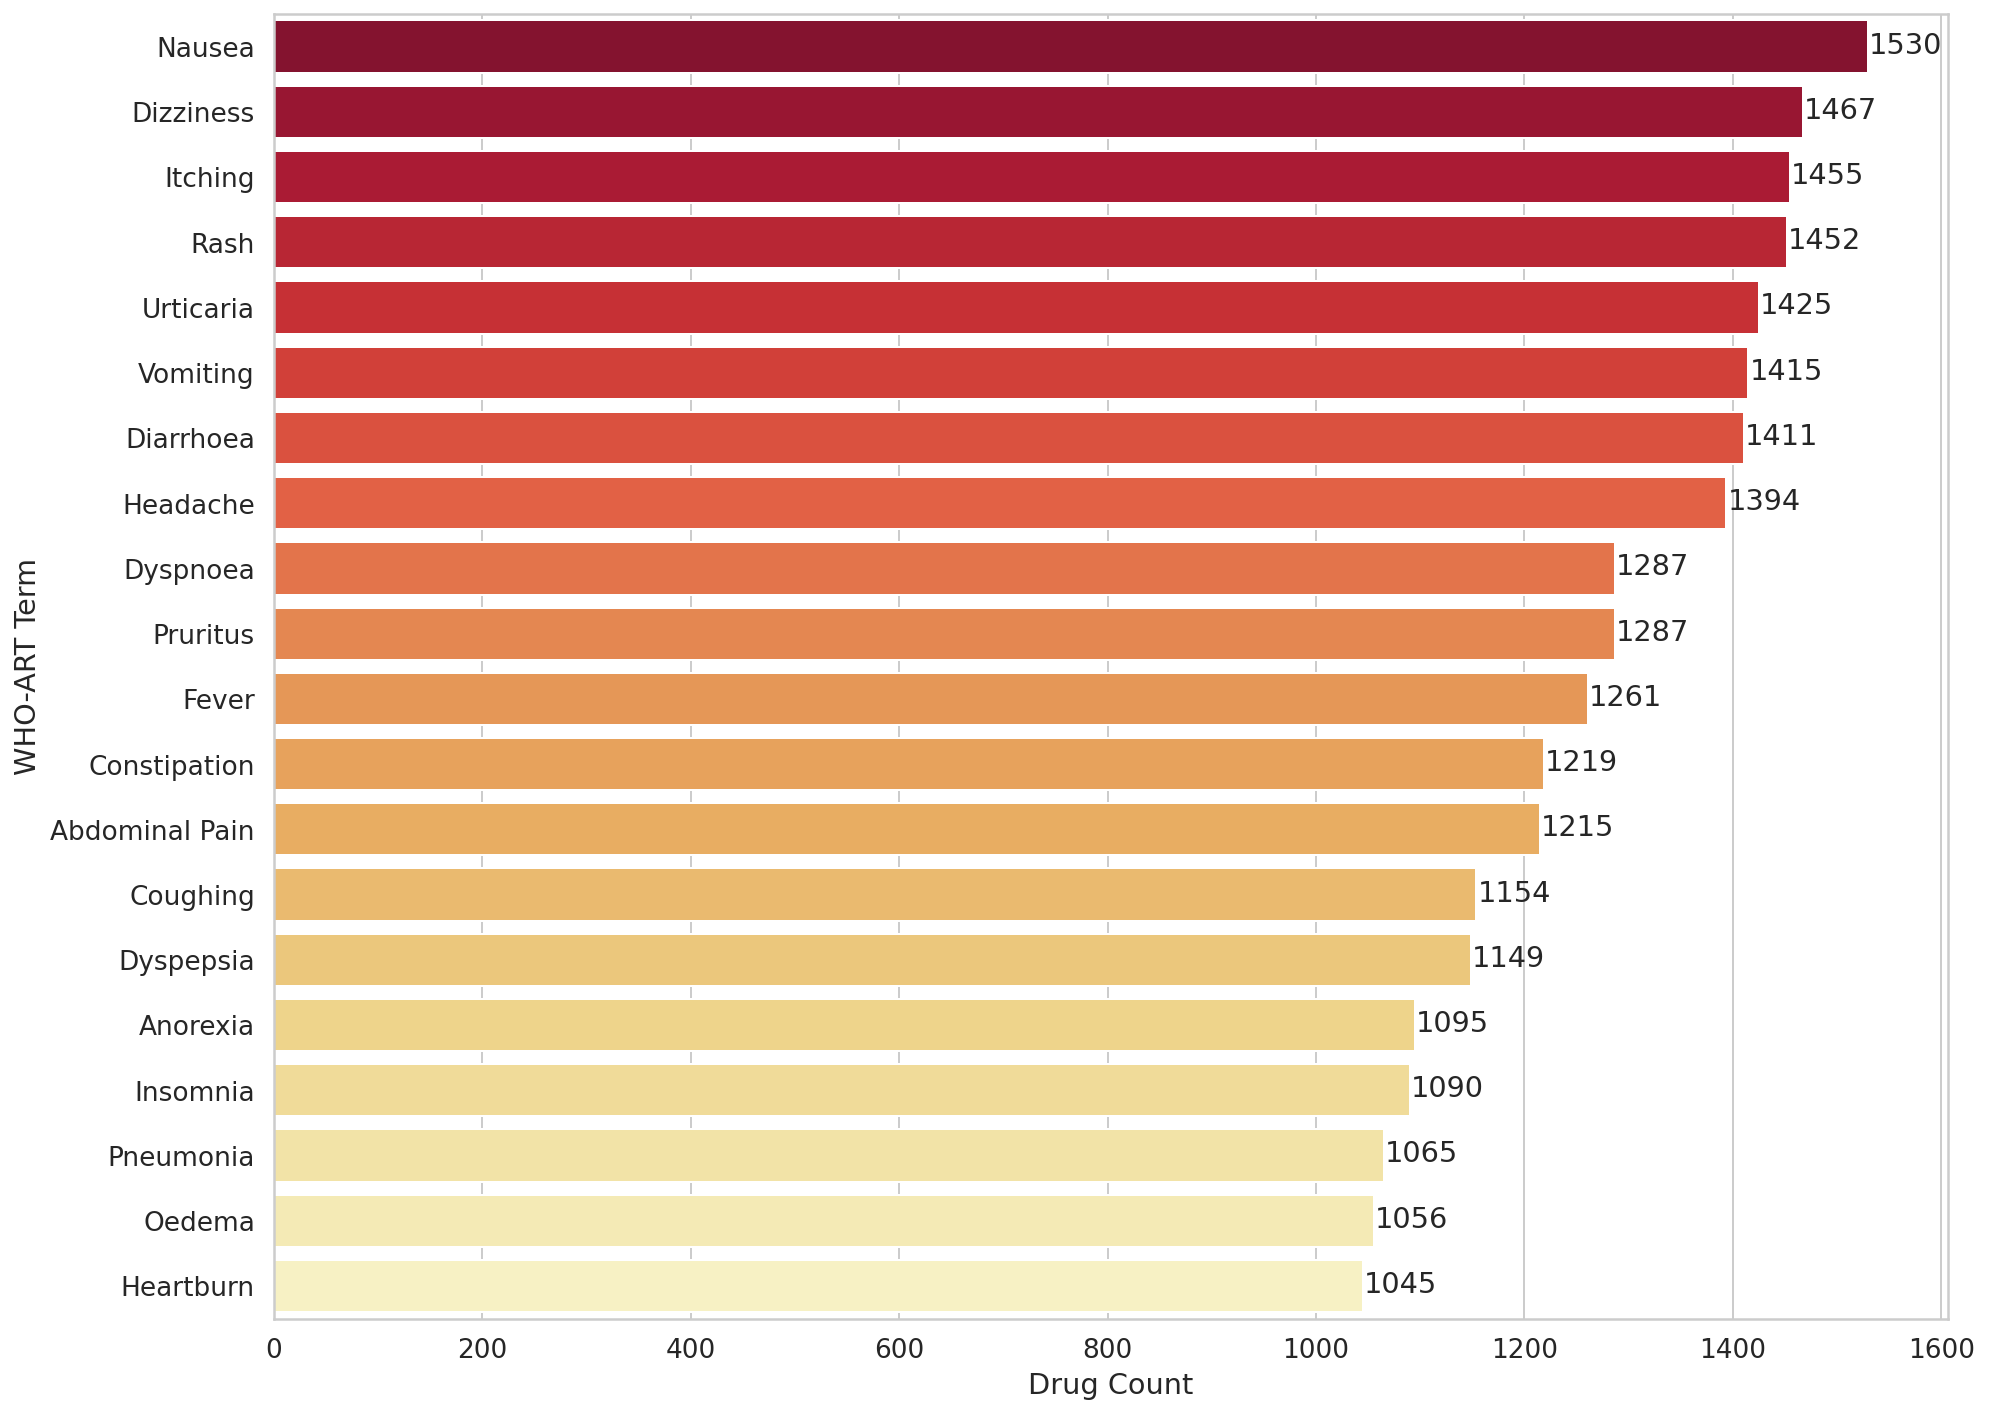

In [100]:
draw_barchart(ka_drug_cnt[:20], 
              figsize=(15,12),
              x='Drug Count', y='WHO-ART Term',
              palette='YlOrRd_r')

### KAERS 약물별 부작용 용어와 부작용 분류 (Anatomical, Causality) 

In [22]:
query = '''
SELECT DISTINCT drug_name, atc_code, LOWER(english_term) AS whoart_term
        , anatomical_1, anatomical_2, causality_1, causality_2, type
FROM kaers_drug_adr kda, kaers_drug kd, kaers_adr ka, 
        kaers_adr_classification kac
WHERE kda.kaers_drug_id = kd.kaers_drug_id
AND kda.kaers_adr_id = ka.kaers_adr_id
AND ka.kaers_adr_id = kac.kaers_adr_id;
'''
columns = ['drug_name','atc_code','whoart_term','anatomical_1','anatomical_2','causality_1', 'causality_2', 'type']

df = execute_query(query, columns)
df

drug_name atc_code  \
0       4-aminosalicylic acid  J04AA01   
1       4-aminosalicylic acid  J04AA01   
2       4-aminosalicylic acid  J04AA01   
3       4-aminosalicylic acid  J04AA01   
4       4-aminosalicylic acid  J04AA01   
...                       ...      ...   
423658               zotepine  N05AX11   
423659               zotepine  N05AX11   
423660               zotepine  N05AX11   
423661               zotepine  N05AX11   
423662               zotepine  N05AX11   

                                       whoart_term          anatomical_1  \
0                             abdominal discomfort      gastrointestinal   
1                                   abdominal pain      gastrointestinal   
2                               acidosis metabolic   endocrine/metabolic   
3       acute generalized exanthematous pustulosis           not defined   
4                                    alt increased               unclear   
...                                            ...                   ...   
423658                                  joint pain       musculoskeletal   
423659                               mood disorder  psychological/mental   
423660                                      nausea               general   
423661                                  somnolence  psychological/mental   
423662                                    vomiting      gastrointestinal   

       anatomical_2             causality_1 causality_2  \
0              None                    None        None   
1              None                    None        None   
2              None  laboratory abnormality        None   
3              None  infection/inflammation        None   
4              None  laboratory abnormality        None   
...             ...                     ...         ...   
423658         None                    None        None   
423659         None                    None        None   
423660         None                    None        None   
423661         None                    None        None   
423662      general                    None        None   

                               type  
0        findings or signs/symptoms  
1                    signs/symptoms  
2               laboratory findings  
3                         diagnosis  
4               laboratory findings  
...                             ...  
423658               signs/symptoms  
423659                    diagnosis  
423660   findings or signs/symptoms  
423661                    diagnosis  
423662  diagnosis or signs/symptoms  

[423663 rows x 8 columns]

### KAERS 약물-부작용 보고 개수

In [159]:
query = '''
SELECT DISTINCT drug_name||' / '||atc_code AS drug,
       drug_name, atc_code, 
       INITCAP(english_term) AS whoart_term, 
       COUNT(*) OVER (PARTITION BY drug_name, atc_code, english_term) report_count
FROM kaers_assessment ks, kaers_drug kd, kaers_adr ka
WHERE ks.kaers_drug_id = kd.kaers_drug_id
AND ks.kaers_adr_id = ka.kaers_adr_id;
'''
columns = ['Drug','Drug name','ATC code','WHO-ART Term','Report Count']

ka_report = execute_query(query, columns)
ka_report

Drug              Drug name ATC code  \
0       4-aminosalicylic acid / J04AA01  4-aminosalicylic acid  J04AA01   
1       4-aminosalicylic acid / J04AA01  4-aminosalicylic acid  J04AA01   
2       4-aminosalicylic acid / J04AA01  4-aminosalicylic acid  J04AA01   
3       4-aminosalicylic acid / J04AA01  4-aminosalicylic acid  J04AA01   
4       4-aminosalicylic acid / J04AA01  4-aminosalicylic acid  J04AA01   
...                                 ...                    ...      ...   
422672                             None    unapproved medicine     None   
422673                             None    unapproved medicine     None   
422674                             None    unapproved medicine     None   
422675                             None    unapproved medicine     None   
422676                             None    unapproved medicine     None   

                                      WHO-ART Term  Report Count  
0                             Abdominal Discomfort             2  
1                                   Abdominal Pain             1  
2                               Acidosis Metabolic             2  
3       Acute Generalized Exanthematous Pustulosis             2  
4                                    Alt Increased             3  
...                                            ...           ...  
422672            White Blood Cell Count Decreased             2  
422673            White Blood Cell Count Increased             1  
422674                                   Wooziness             3  
422675                                  Xerostomia             2  
422676                                 Yellow Skin             1  

[422677 rows x 5 columns]

In [160]:
# 약물별 부작용 개수 상위 20개와 부작용별 약물 개수 상위 20개 데이터 추출
count = 20
ka_report_ext = ka_report[ka_report['Drug'].isin(list(ka_adr_cnt[:count]['Drug']))].drop(['Drug name','ATC code'], axis=1)
ka_report_ext = ka_report_ext[ka_report['WHO-ART Term'].isin(list(ka_drug_cnt[:count]['WHO-ART Term']))]
ka_report_ext

Drug    WHO-ART Term  Report Count
2639              acetylcysteine / R05CB01  Abdominal Pain           146
2688              acetylcysteine / R05CB01        Anorexia           177
2899              acetylcysteine / R05CB01    Constipation           479
2909              acetylcysteine / R05CB01        Coughing           375
2958              acetylcysteine / R05CB01       Diarrhoea           936
...                                    ...             ...           ...
393701  tramadol and paracetamol / N02AJ13       Pneumonia           292
393733  tramadol and paracetamol / N02AJ13        Pruritus           494
393757  tramadol and paracetamol / N02AJ13            Rash           633
394028  tramadol and paracetamol / N02AJ13       Urticaria           596
394069  tramadol and paracetamol / N02AJ13        Vomiting          5859

[400 rows x 3 columns]

In [161]:
# 약물별 부작용 개수 상위 20개의 부작용별 약물 개수 상위 20개 피봇 테이블
ka_report_pivot_d = pd.pivot_table(ka_report_part, index=['Drug'], columns='WHO-ART Term', aggfunc='sum', fill_value=0)
ka_report_pivot_d

Report Count           \
WHO-ART Term                                       Abdominal Pain Anorexia   
Drug                                                                         
Calcium, combinations with vitamin D and/or oth...            124      108   
acetylcysteine / R05CB01                                      146      177   
acetylsalicylic acid / B01AC06                                114      136   
acetylsalicylic acid / N02BA01                                159      104   
amlodipine / C08CA01                                          191      216   
atorvastatin / C10AA05                                        181      221   
carvedilol / C07AG02                                           79       95   
chlorphenamine / R06AB04                                      259      290   
clopidogrel / B01AC04                                          83       90   
dexamethasone / H02AB02                                       407      430   
esomeprazole / A02BC05                                        238      191   
furosemide / C03CA01                                          242      182   
metformin / A10BA02                                           192      262   
mosapride / A03FA09                                           265      201   
paracetamol / N02BE01                                         333      299   
prednisolone / H02AB06                                        200      192   
ranitidine / A02BA02                                          328      211   
rebamipide / A02BX14                                          187      153   
rosuvastatin / C10AA07                                        124      143   
tramadol and paracetamol / N02AJ13                            349      376   

                                                                          \
WHO-ART Term                                       Constipation Coughing   
Drug                                                                       
Calcium, combinations with vitamin D and/or oth...          393      108   
acetylcysteine / R05CB01                                    479      375   
acetylsalicylic acid / B01AC06                              314      237   
acetylsalicylic acid / N02BA01                              157      362   
amlodipine / C08CA01                                        407      198   
atorvastatin / C10AA05                                      567      380   
carvedilol / C07AG02                                        170      261   
chlorphenamine / R06AB04                                    505      346   
clopidogrel / B01AC04                                       252      142   
dexamethasone / H02AB02                                     859      403   
esomeprazole / A02BC05                                      430      166   
furosemide / C03CA01                                        438      302   
metformin / A10BA02                                         463      245   
mosapride / A03FA09                                         827      150   
paracetamol / N02BE01                                       867      444   
prednisolone / H02AB06                                      524      185   
ranitidine / A02BA02                                        462      249   
rebamipide / A02BX14                                        693      205   
rosuvastatin / C10AA07                                      312      229   
tramadol and paracetamol / N02AJ13                         1953      222   

                                                                        \
WHO-ART Term                                       Diarrhoea Dizziness   
Drug                                                                     
Calcium, combinations with vitamin D and/or oth...       296       260   
acetylcysteine / R05CB01                                 936       542   
acetylsalicylic acid / B01AC06                           284       671   
acetylsalicylic acid / N02BA01                           235     

In [162]:
# 부작용별 약물 개수 상위 20개의 약물별 부작용 개수 상위 20개 피봇 테이블
ka_report_pivot_a = pd.pivot_table(ka_report_part, index=['WHO-ART Term'], columns='Drug', aggfunc='sum', fill_value=0)
ka_report_pivot_a

Report Count  \
Drug           Calcium, combinations with vitamin D and/or other drugs / A12AX   
WHO-ART Term                                                                     
Abdominal Pain                                                124                
Anorexia                                                      108                
Constipation                                                  393                
Coughing                                                      108                
Diarrhoea                                                     296                
Dizziness                                                     260                
Dyspepsia                                                     236                
Dyspnoea                                                      111                
Fever                                                         158                
Headache                                                      191                
Heartburn                                                     182                
Insomnia                                                      107                
Itching                                                       126                
Nausea                                                        439                
Oedema                                                         63                
Pneumonia                                                     239                
Pruritus                                                       90                
Rash                                                          133                
Urticaria                                                      67                
Vomiting                                                      186                

                                                                        \
Drug           acetylcysteine / R05CB01 acetylsalicylic acid / B01AC06   
WHO-ART Term                                                             
Abdominal Pain                      146                            114   
Anorexia                            177                            136   
Constipation                        479                            314   
Coughing                            375                            237   
Diarrhoea                           936                            284   
Dizziness                           542                            671   
Dyspepsia                           197                            216   
Dyspnoea                            454                            387   
Fever                               268                            145   
Headache                            275                            371   
Heartburn                           433                            250   
Insomnia                            181                            131   
Itching                             425                            390   
Nausea                             1784                            483   
Oedema                               83                            146   
Pneumonia                           339                            212   
Pruritus                            212                            177   
Rash                                443                            253   
Urticaria                           338                            438   
Vomiting                            613                            245   

                                                                    \
Drug           acetylsalicylic acid / N02BA01 amlodipine / C08CA01   
WHO-ART Term                                                         
Abdominal Pain                            159                  191   
Anorexia                                  104                  216   
Constipation                              157                  407   
Coughing                                  362           

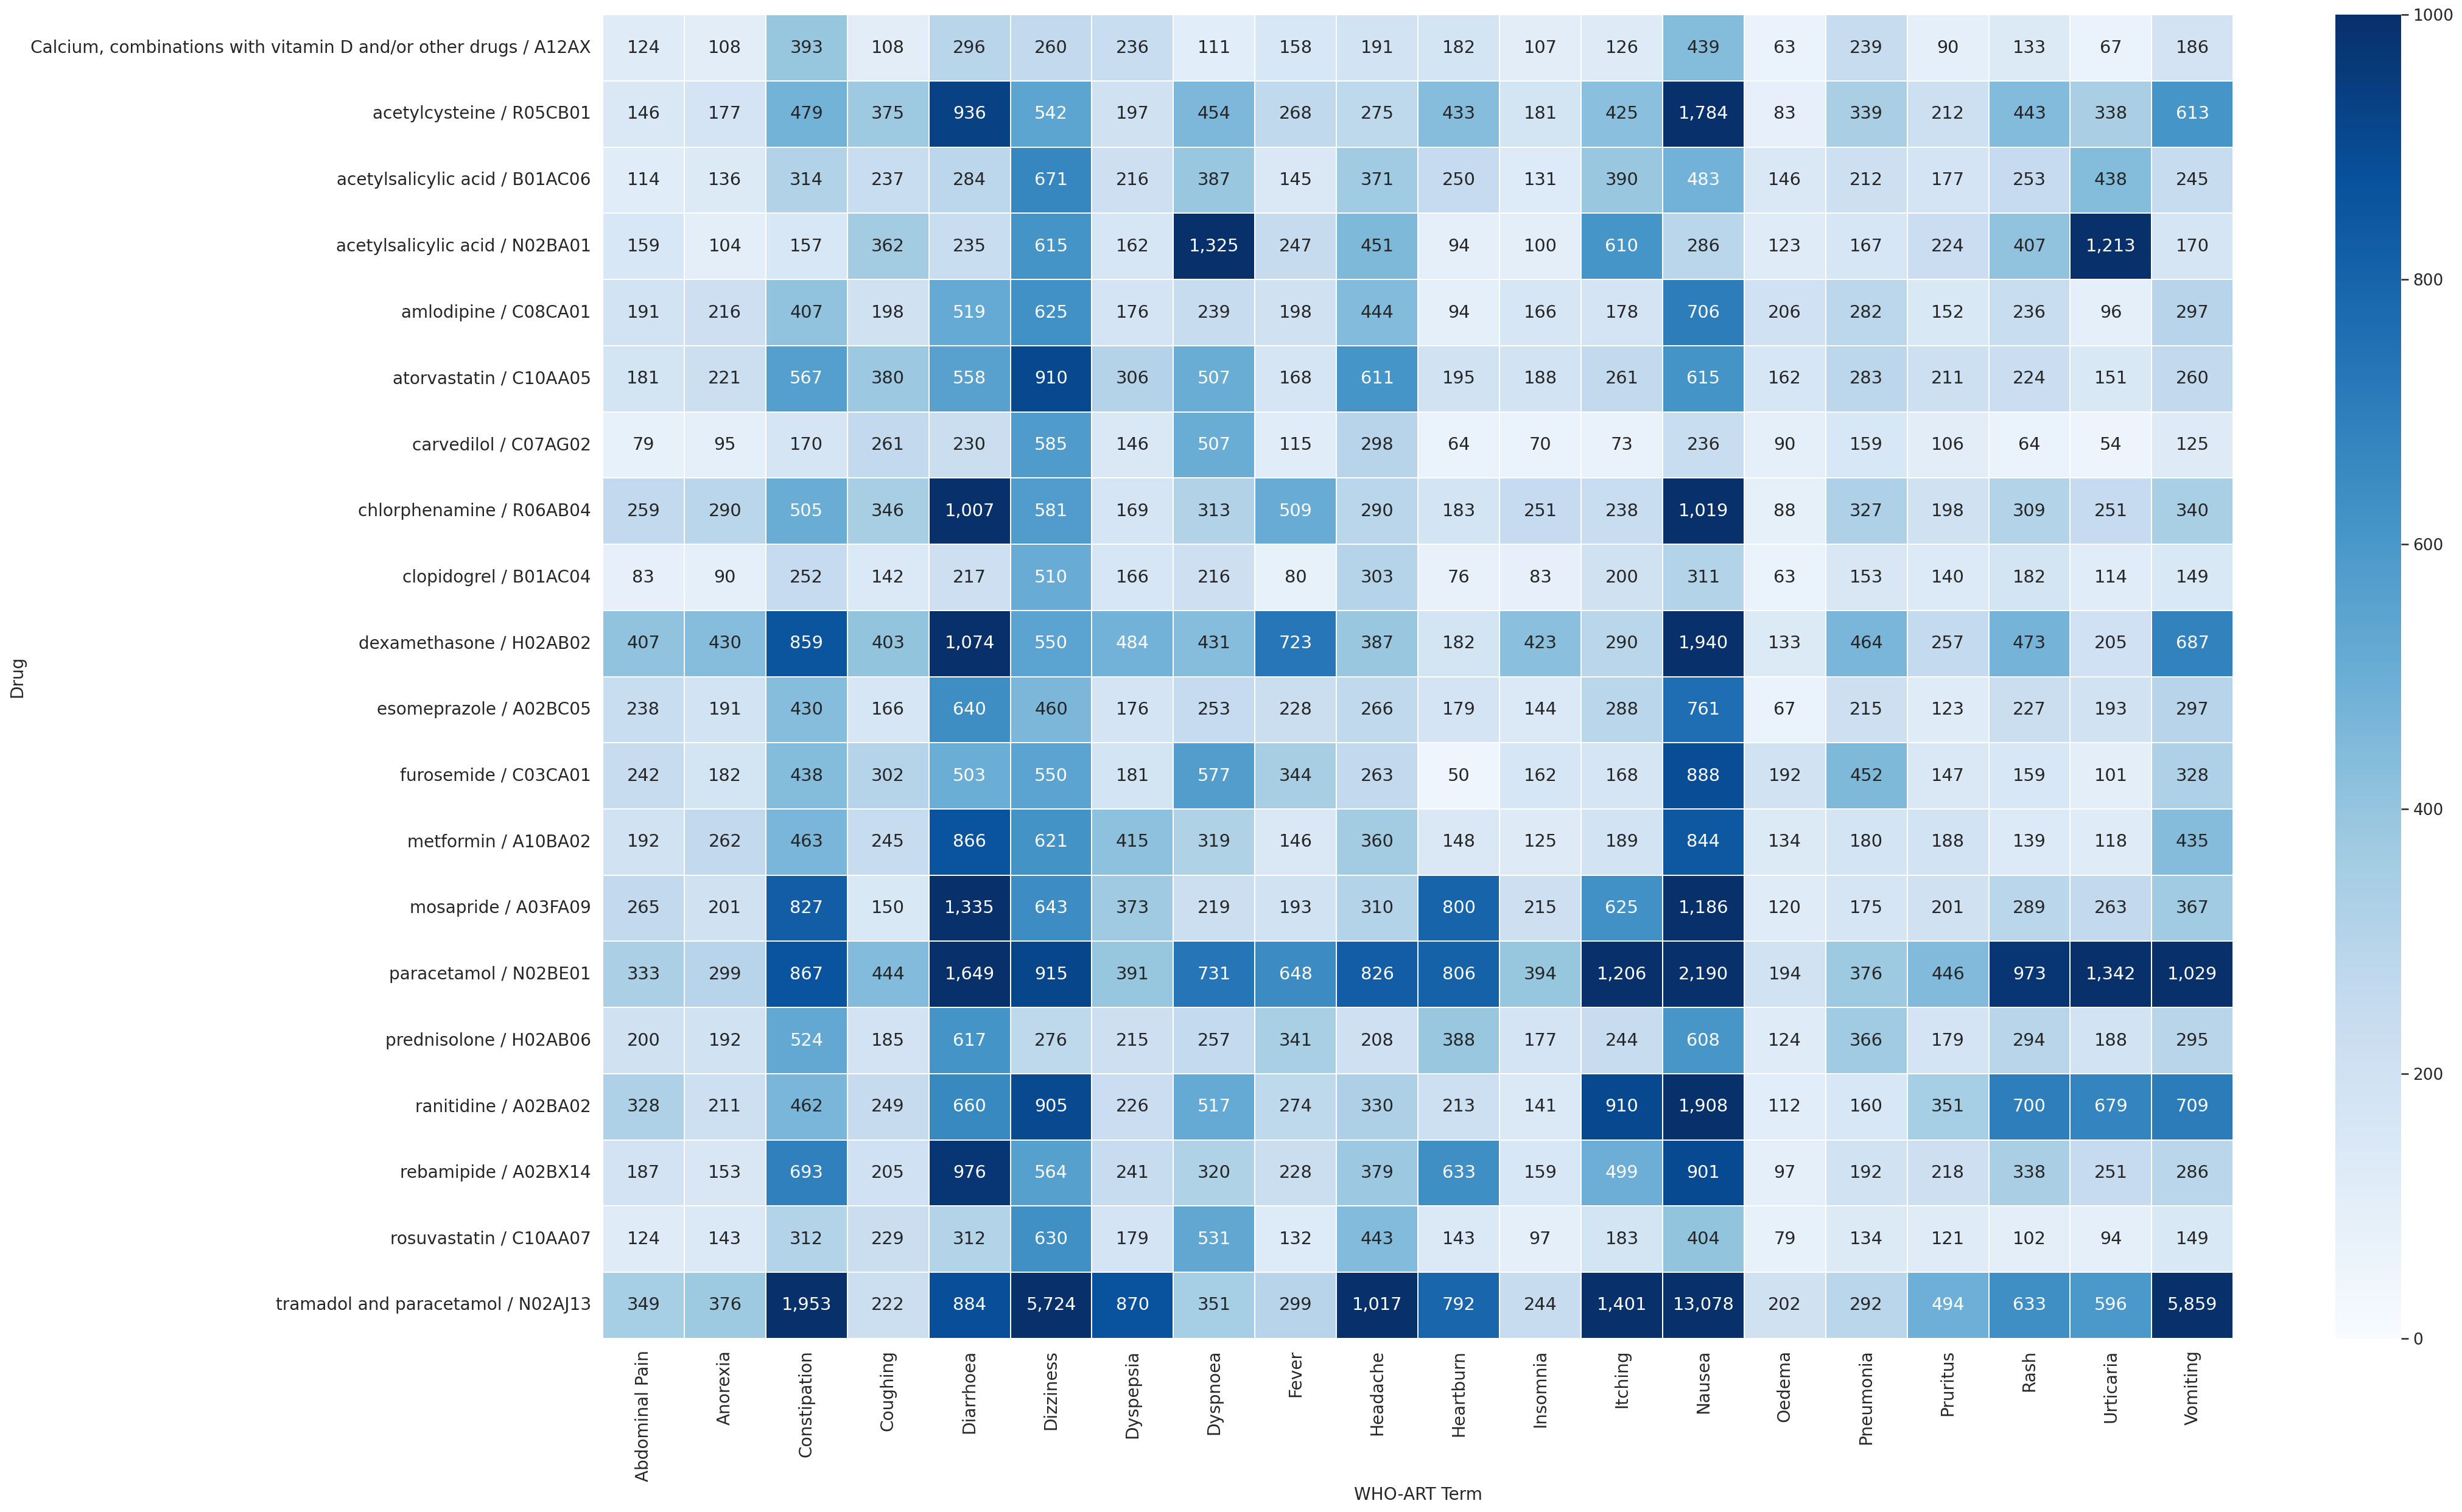

In [163]:
draw_heatmap(ka_report_pivot_d, "WHO-ART Term", "Drug", palette='Blues')

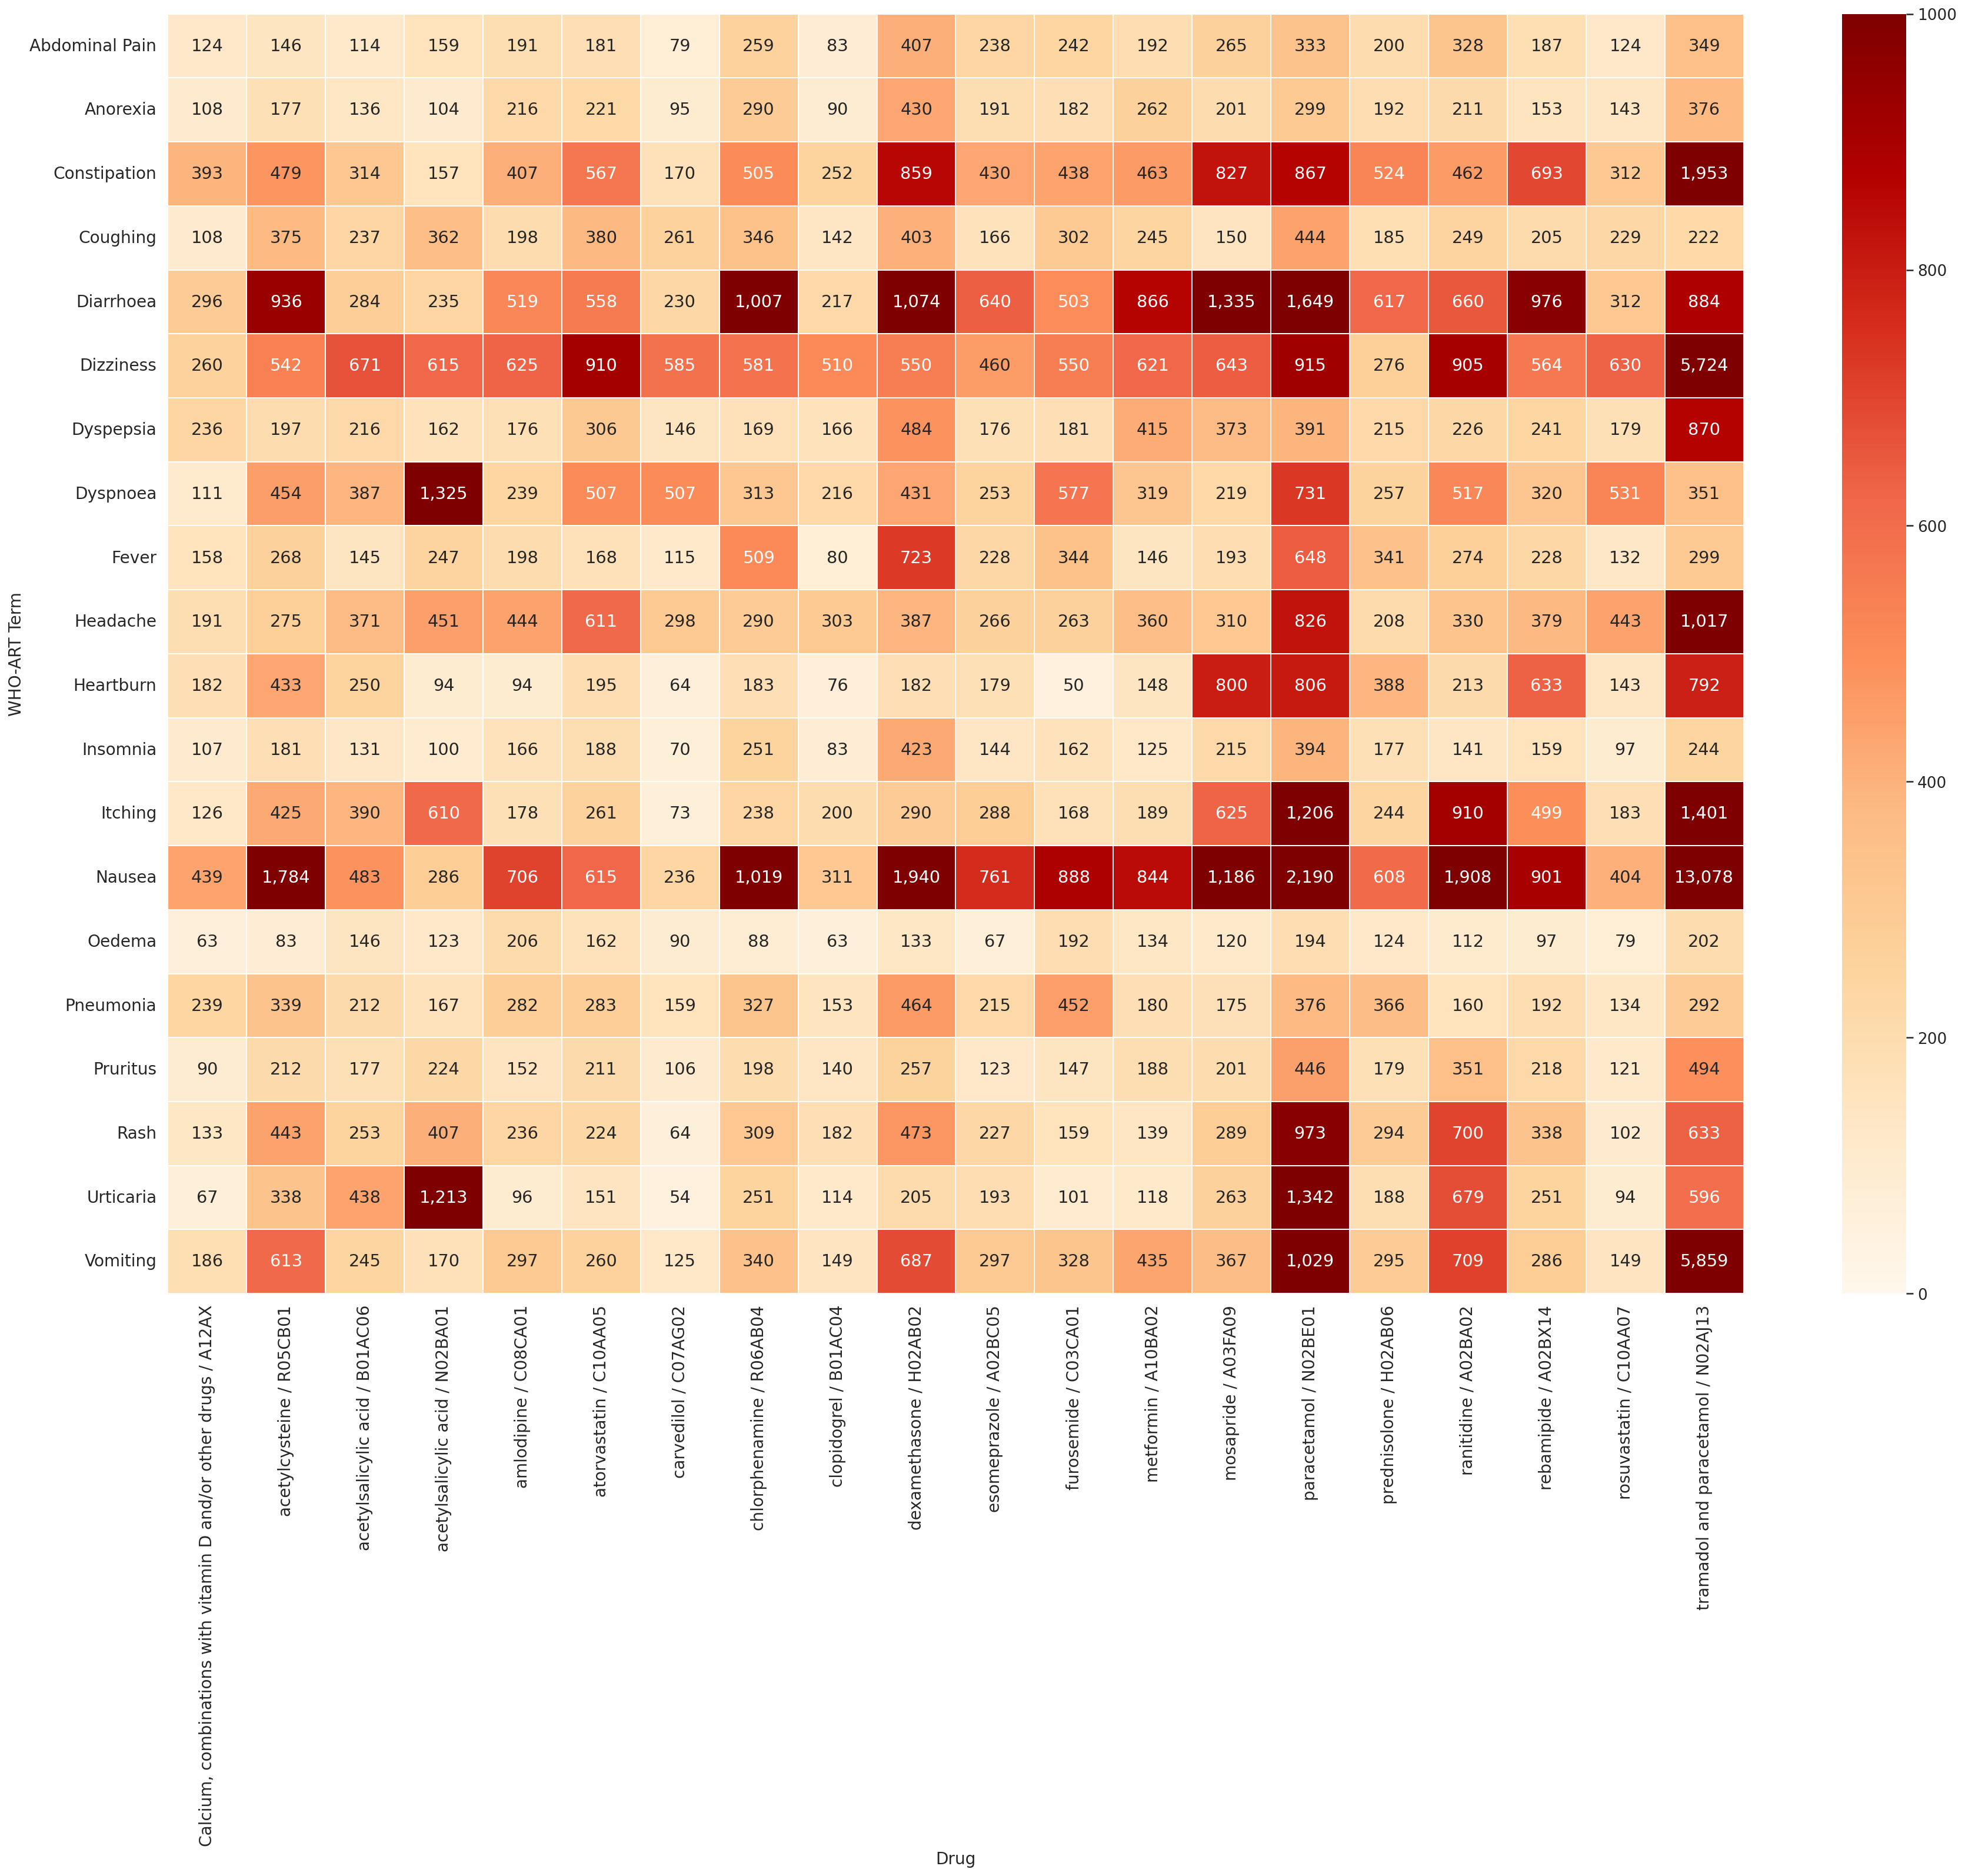

In [164]:
draw_heatmap(ka_report_pivot_a, "Drug", "WHO-ART Term", palette='OrRd')

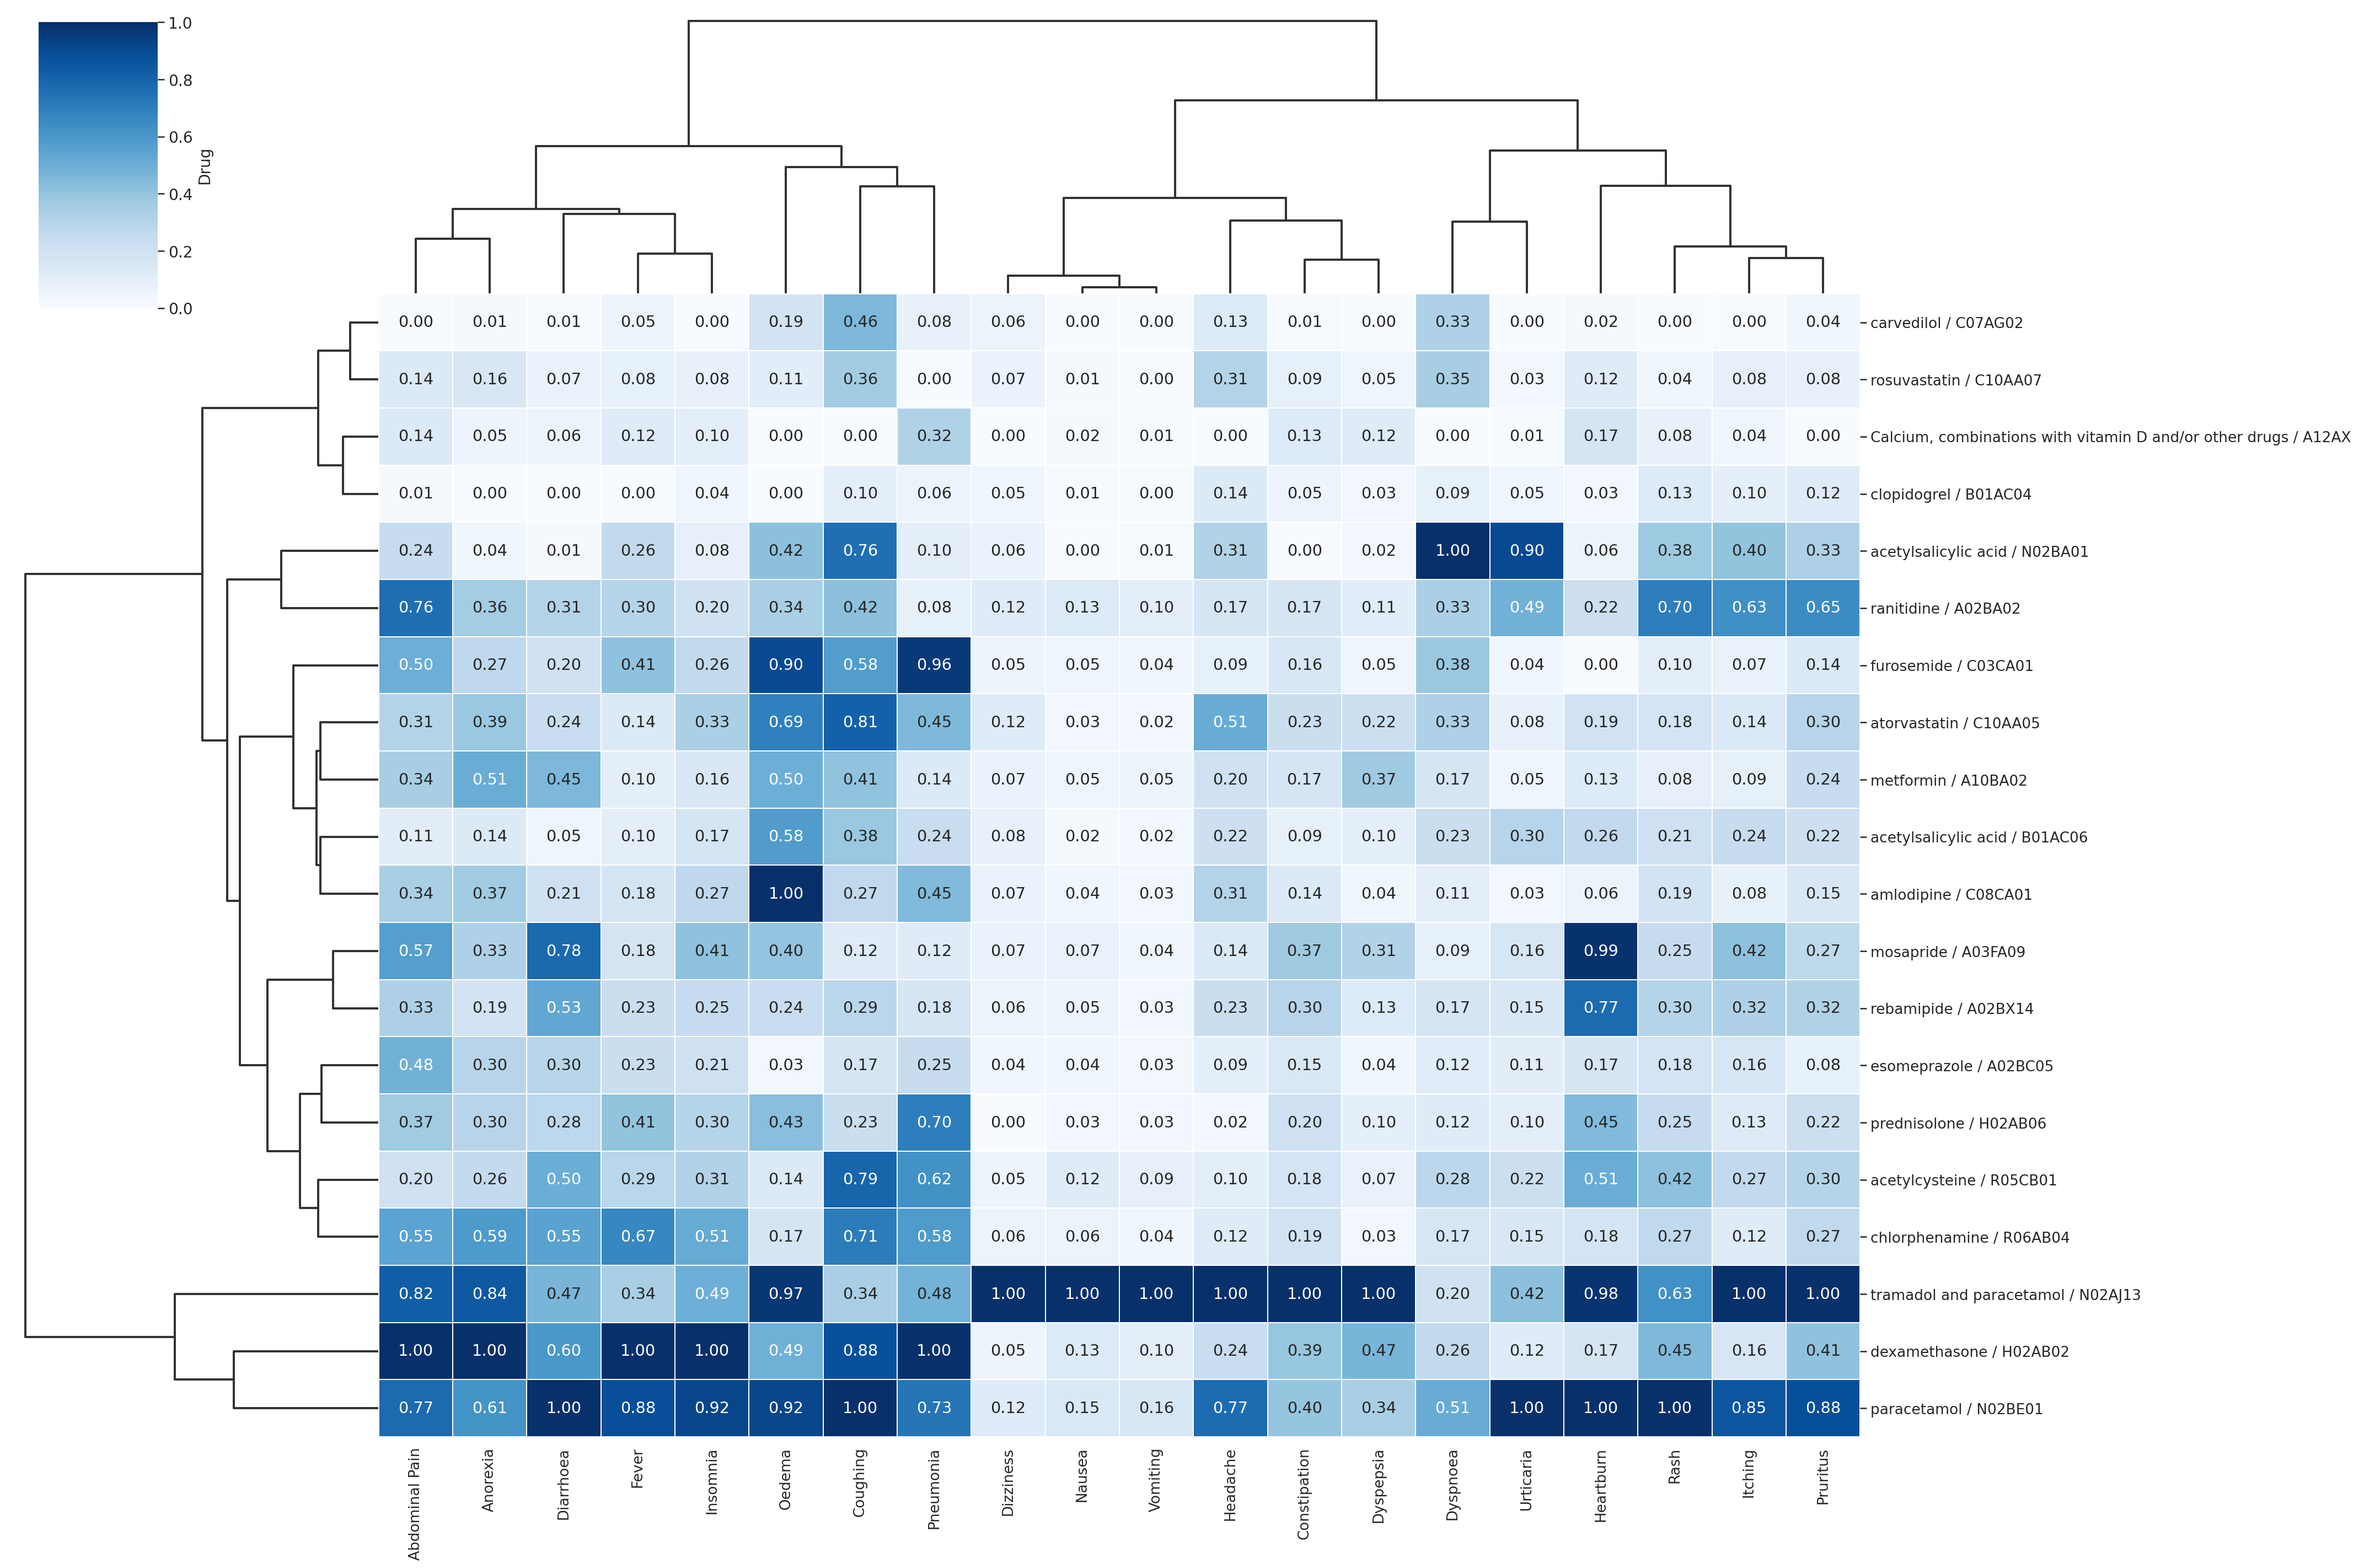

In [166]:
draw_clustermap(ka_report_pivot_d, 'WHO-ART Term', 'Drug', palette='Blues', isNormalized=True)

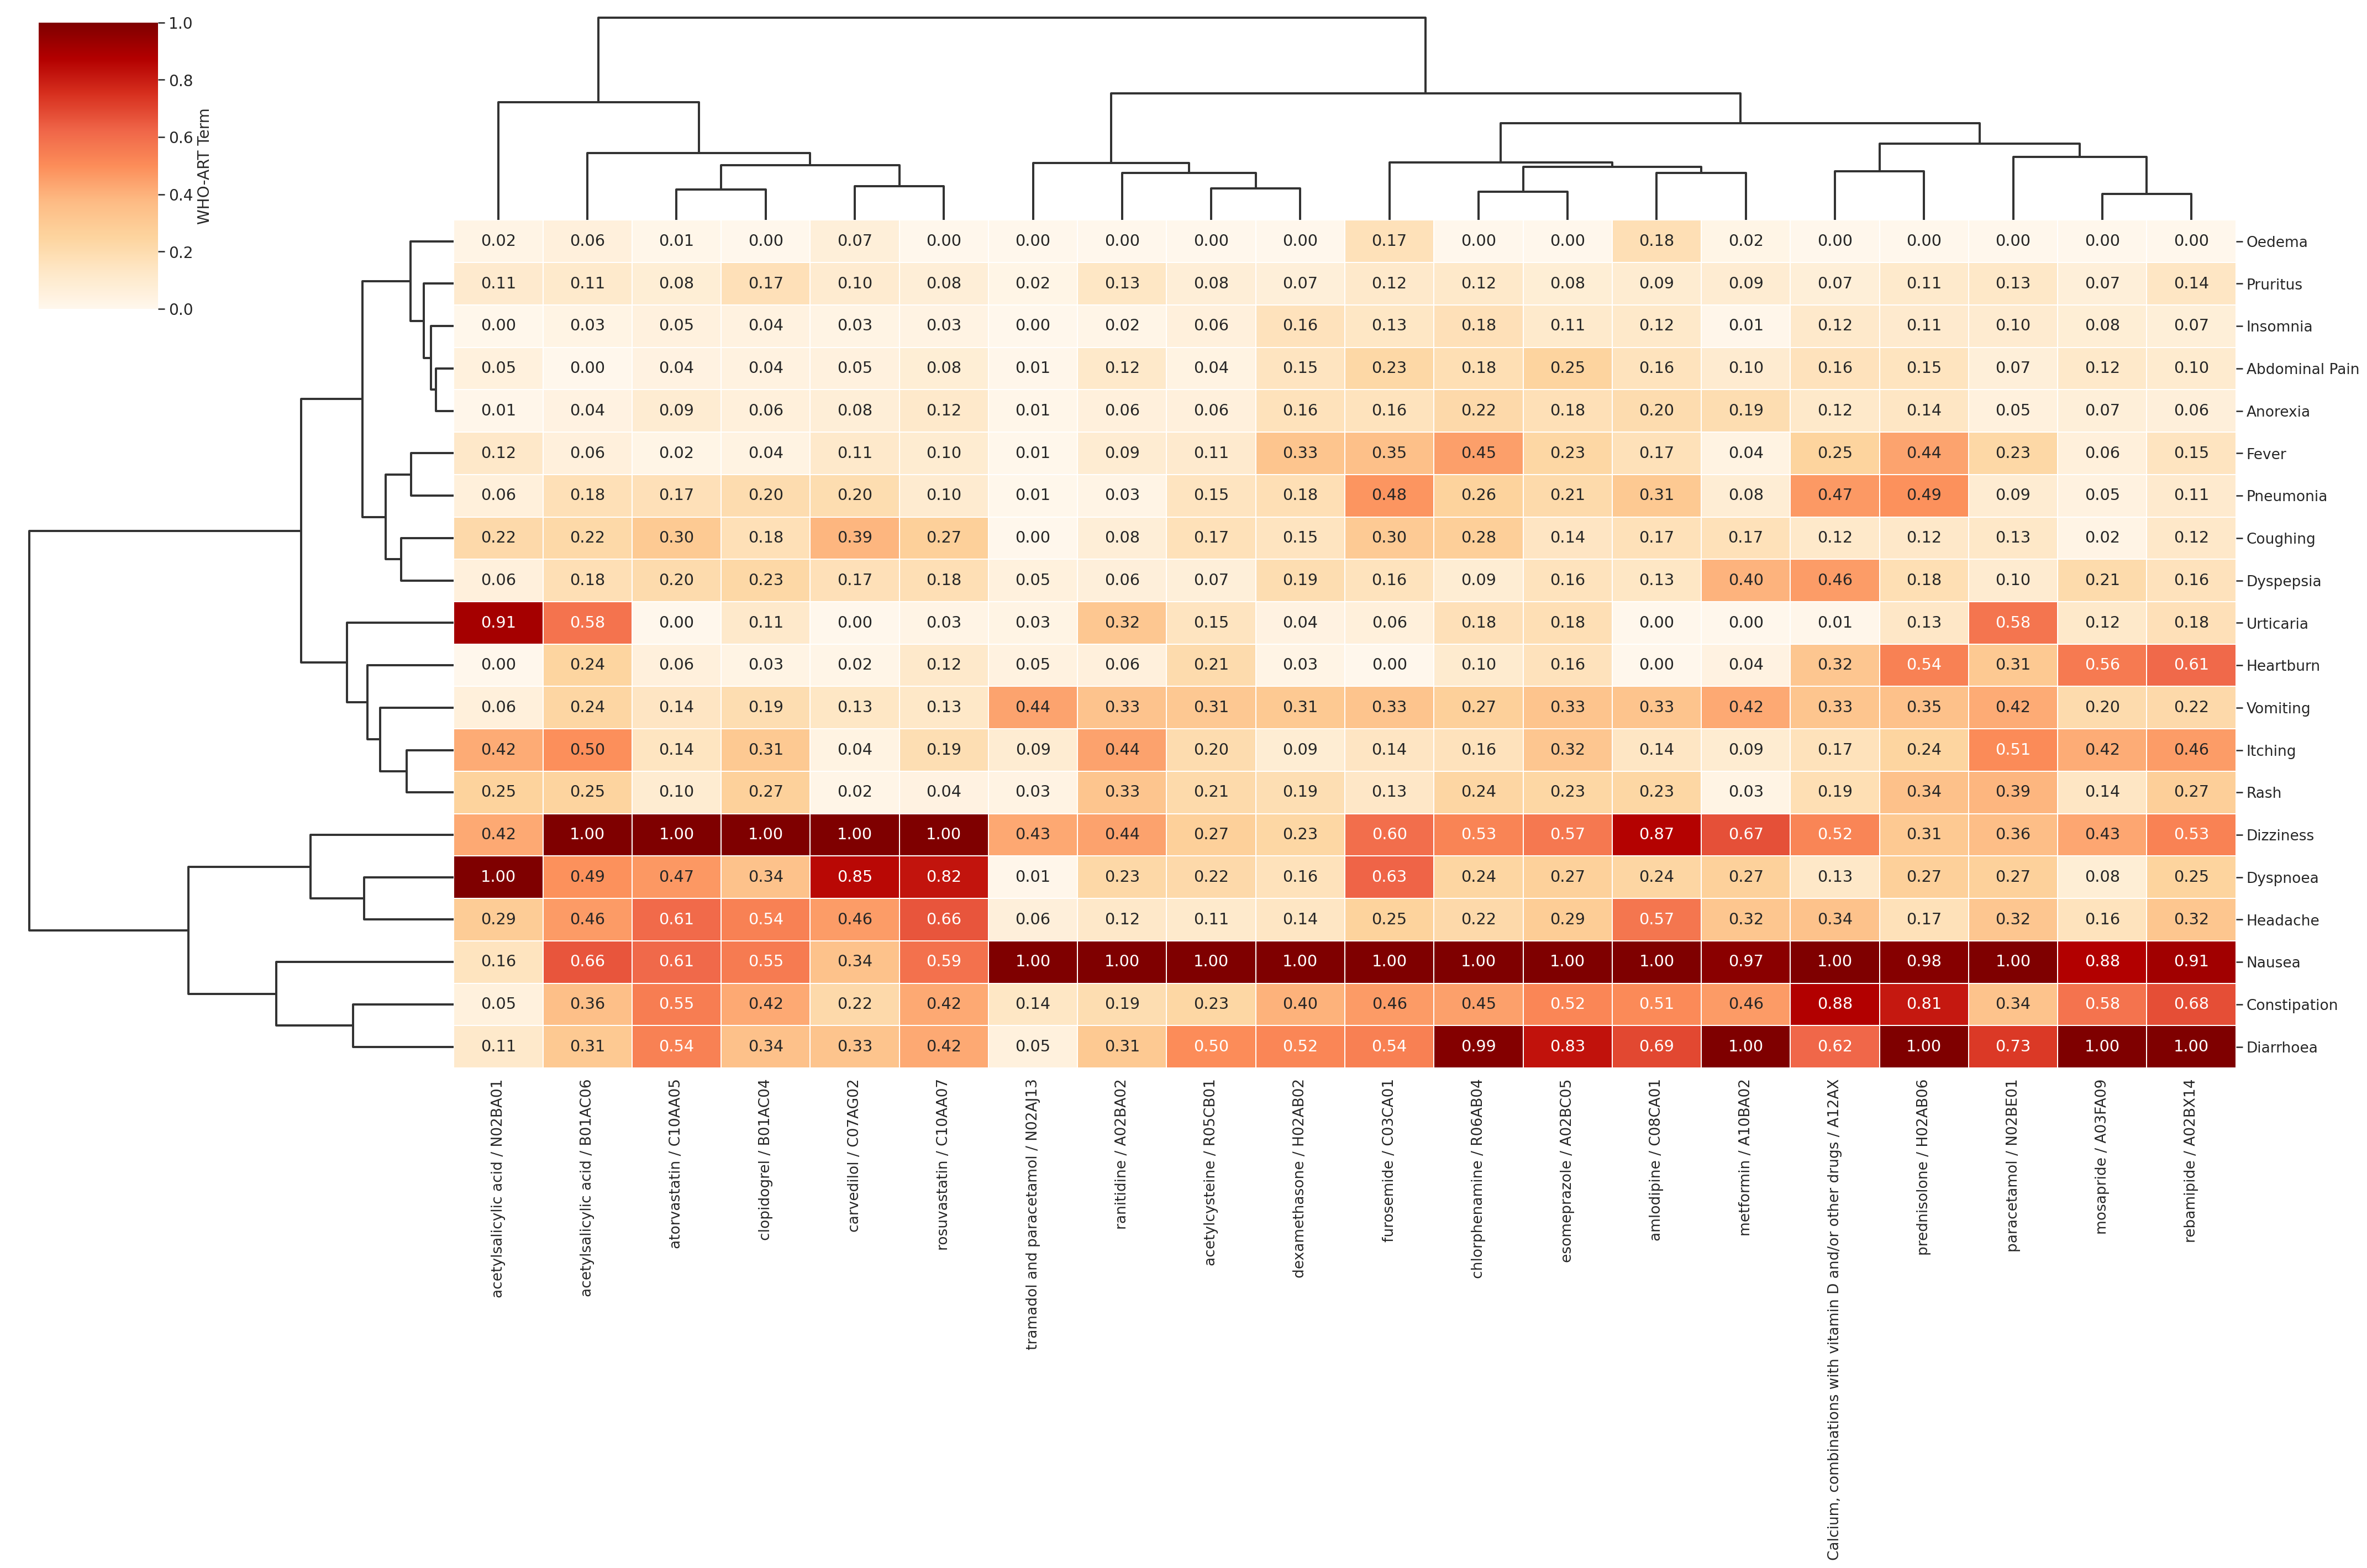

In [167]:
draw_clustermap(ka_report_pivot_a, 'Drug', 'WHO-ART Term', palette='OrRd', isNormalized=True)

###  KAERS 약물-부작용 인과성 평가 결과 확인

In [24]:
query = '''
SELECT DISTINCT drug_name, atc_code, 
       LOWER(english_term) AS whoart_term, assessment
FROM kaers_assessment ks, kaers_drug kd, kaers_adr ka
WHERE ks.kaers_drug_id = kd.kaers_drug_id
AND ks.kaers_adr_id = ka.kaers_adr_id
AND ks.assessment IS NOT NULL;
'''
columns = ['drug_name','atc_code','whoart_term','assessment']

df = execute_query(query, columns)
df

drug_name atc_code     whoart_term    assessment
0       4-aminosalicylic acid  J04AA01  abdominal pain      POSSIBLE
1       4-aminosalicylic acid  J04AA01   alt increased  UNCLASSIFIED
2       4-aminosalicylic acid  J04AA01        anorexia      POSSIBLE
3       4-aminosalicylic acid  J04AA01      arthralgia      POSSIBLE
4       4-aminosalicylic acid  J04AA01   ast increased  UNCLASSIFIED
...                       ...      ...             ...           ...
339051               zotepine  N05AX11        headache      POSSIBLE
339052               zotepine  N05AX11    hypertension      POSSIBLE
339053               zotepine  N05AX11          nausea      POSSIBLE
339054               zotepine  N05AX11      somnolence      POSSIBLE
339055               zotepine  N05AX11        vomiting      POSSIBLE

[339056 rows x 4 columns]

In [35]:
pd.pivot_table(df, index='whoart_term', columns='assessment', values=['drug_name'], aggfunc=['count'], fill_value=0)

count                                   \
                                 drug_name                                    
assessment                         CERTAIN NOT_APPLICABLE POSSIBLE PROBABLE   
whoart_term                                                                   
11-oxysteroid activity increased         0              0        1        0   
abdomen enlarged                         0              1       10        2   
abdominal adhesions                      0              0        1        0   
abdominal discomfort                    22             21      334       96   
abdominal distension                     6             23      152       36   
...                                    ...            ...      ...      ...   
xerostomia                               2              1       74       18   
yawning                                  2              0       32        9   
yawning excessive                        1              0       21        4   
yellow skin                              0              0       26        1   
zinc deficiency                          0              0        1        0   

                                                                     
                                                                     
assessment                       UNASSESSABLE UNCLASSIFIED UNLIKELY  
whoart_term                                                          
11-oxysteroid activity increased            1            0        0  
abdomen enlarged                            2            0       18  
abdominal adhesions                         1            0       18  
abdominal discomfort                      128           15      171  
abdominal distension                       82            4      135  
...                                       ...          ...      ...  
xerostomia                                  4            3       41  
yawning                                     0            3       13  
yawning excessive                           0            0        5  
yellow skin                                 0            0       10  
zinc deficiency                             0            0        0  

[4074 rows x 7 columns]

In [ ]:
cursor.close()
conn.close()